In [1]:
import os
import shutil
import pandas as pd

# Output directories for organized images
output_train_dir = '/media/mydisk/ICDCIT/Split_APTOS_preprocessed (Copy)/train'
output_val_dir = '/media/mydisk/ICDCIT/Split_APTOS_preprocessed (Copy)/val'
output_test_dir = '/media/mydisk/ICDCIT/Split_APTOS_preprocessed (Copy)/test'


In [2]:
from tensorflow.keras import backend as K
K.clear_session()

2024-12-06 12:25:00.309213: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-06 12:25:00.451988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733468100.516093   22473 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733468100.532886   22473 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 12:25:00.681824: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
import tensorflow as tf

# List physical devices
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Optionally, list details

print(tf.config.list_physical_devices('GPU'))


Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from tensorflow.keras import mixed_precision

# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

In [5]:
import tensorflow as tf
import os

# Constants
TARGET_SIZE = (224, 224)
BATCH_SIZE = 64
NUM_CLASSES = len(os.listdir(output_train_dir)) 

# Data Parsing and Augmentation
def parse_tfrecord(example):
    # Define TFRecord schema
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    # Parse example
    parsed = tf.io.parse_single_example(example, feature_description)
    # Decode and preprocess image
    image = tf.io.decode_jpeg(parsed['image'], channels=3)
    image = tf.image.resize(image, TARGET_SIZE) / 255.0  # Normalize
    
    label = tf.one_hot(parsed['label'], depth=NUM_CLASSES)
    return image, label

# Dataset Loader
def load_tfrecord_dataset(filenames, batch_size, shuffle=True):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(lambda x: parse_tfrecord(x), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    return dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)



In [6]:
train_dataset = load_tfrecord_dataset(['/media/mydisk/ICDCIT/TFRecords_preprocessed_APTOS_resampled/train.tfrecord'], BATCH_SIZE)
val_dataset = load_tfrecord_dataset(['/media/mydisk/ICDCIT/TFRecords_preprocessed_APTOS_resampled/val.tfrecord'], BATCH_SIZE, shuffle=False)  # No augmentation
test_dataset = load_tfrecord_dataset(['/media/mydisk/ICDCIT/TFRecords_preprocessed_APTOS_resampled/test.tfrecord'], BATCH_SIZE, shuffle=False)  # No augmentation


I0000 00:00:1733468109.511207   22473 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5610 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:64:00.0, compute capability: 8.9


In [7]:
# Function to count the number of samples in the TFRecord
def count_samples(tfrecord_filename):
    count = 0
    for record in tf.data.TFRecordDataset(tfrecord_filename):
        count += 1
    return count

# Calculate the number of samples in the training TFRecord
train_samples = count_samples('/media/mydisk/ICDCIT/TFRecords_preprocessed_APTOS_resampled/train.tfrecord')
val_samples = count_samples('/media/mydisk/ICDCIT/TFRecords_preprocessed_APTOS_resampled/val.tfrecord')

print(f'val_samples: {val_samples}')
print(f'train_samples: {train_samples}')

2024-12-06 12:25:10.618025: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144
2024-12-06 12:25:22.900841: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


val_samples: 732
train_samples: 6094


2024-12-06 12:25:24.064635: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
from collections import Counter

def calculate_class_weights(data_dir):
    class_counts = Counter()
    class_names = sorted(os.listdir(data_dir))
    
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        num_samples = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        class_counts[label] += num_samples
    
    # Total number of samples
    total_samples = sum(class_counts.values())
    num_classes = len(class_counts)
    
    # Calculate class weights
    class_weights = {i: total_samples / (num_classes * count) for i, count in class_counts.items()}
    
    return class_weights, class_counts

# Calculate class weights from the training directory
class_weights, class_counts = calculate_class_weights(output_train_dir)
print(f'Class weights: {class_weights}')


Class weights: {0: 0.6870349492671928, 1: 0.9536776212832551, 2: 0.7413625304136253, 3: 1.7117977528089887, 4: 1.77667638483965}


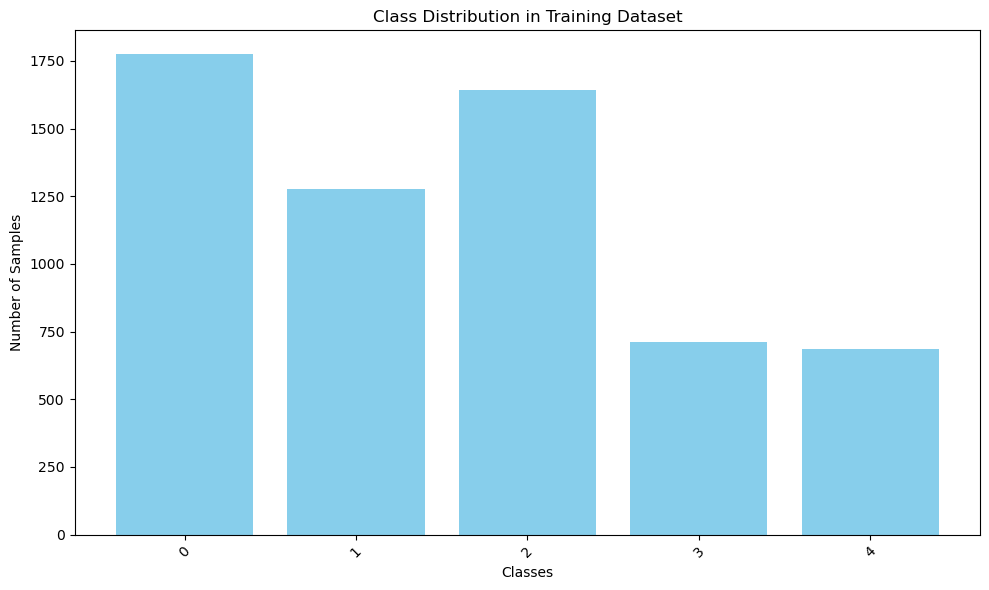

In [9]:
import matplotlib.pyplot as plt

def plot_class_distribution(class_counts):
    # Extract class names and counts
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution in Training Dataset')
    plt.xticks(rotation=45)  # Rotate class labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
    plt.show()

# Call the function with your class counts dictionary
plot_class_distribution(class_counts)


In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import Optional

class SimpleMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, every_n_epochs: int = 5, save_plots: bool = False, plot_path: str = 'accuracy_loss_plot_preprocessed_resampled.png'):
        super().__init__()
        self.every_n_epochs = every_n_epochs
        self.save_plots = save_plots
        self.plot_path = plot_path
        self.history = {
            'epochs': [],
            'train_accuracy': [],
            'val_accuracy': [],
            'train_loss': [],
            'val_loss': []
        }

    def on_epoch_end(self, epoch: int, logs: Optional[dict] = None) -> None:
        """Store accuracy and loss at the end of each epoch."""
        if logs is None:
            logs = {}
            
        # Append accuracy and loss to history
        self.history['epochs'].append(epoch + 1)
        self.history['train_accuracy'].append(logs.get('accuracy', 0))
        self.history['val_accuracy'].append(logs.get('val_accuracy', 0))
        self.history['train_loss'].append(logs.get('loss', 0))
        self.history['val_loss'].append(logs.get('val_loss', 0))
        
        # Log the results for this epoch
        tf.print(f'Epoch {epoch + 1}: Train Accuracy: {logs.get("accuracy", 0):.4f}, Val Accuracy: {logs.get("val_accuracy", 0):.4f}, '
                 f'Train Loss: {logs.get("loss", 0):.4f}, Val Loss: {logs.get("val_loss", 0):.4f}')
        
        # Plot the metrics every n epochs or at the last epoch
        if (epoch + 1) % self.every_n_epochs == 0 or epoch == self.params['epochs'] - 1:
            self.plot_metrics()

    def plot_metrics(self) -> None:
        """Plot accuracy and loss over epochs."""
        try:
            # Create a new figure for each plot to avoid overlapping
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))

            # Plot accuracy
            axes[0].plot(self.history['epochs'], self.history['train_accuracy'], label='Train Accuracy', marker='o')
            axes[0].plot(self.history['epochs'], self.history['val_accuracy'], label='Val Accuracy', marker='o')
            axes[0].set_title('Accuracy over Epochs')
            axes[0].set_xlabel('Epochs')
            axes[0].set_ylabel('Accuracy')
            axes[0].legend()
            axes[0].grid(True)

            # Plot loss
            axes[1].plot(self.history['epochs'], self.history['train_loss'], label='Train Loss', marker='o')
            axes[1].plot(self.history['epochs'], self.history['val_loss'], label='Val Loss', marker='o')
            axes[1].set_title('Loss over Epochs')
            axes[1].set_xlabel('Epochs')
            axes[1].set_ylabel('Loss')
            axes[1].legend()
            axes[1].grid(True)

            plt.tight_layout()
            
            # Save or show the plot
            if self.save_plots:
                plt.savefig(self.plot_path)
                plt.close()  # Close the figure to avoid display in interactive environments
            else:
                plt.show()  # Show the plot in interactive mode
                
        except Exception as e:
            tf.print(f"Error plotting metrics: {str(e)}")


In [11]:
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (Input, GlobalAveragePooling2D, Dense, 
                                     Dropout, BatchNormalization, Conv2D, 
                                     multiply, Lambda)
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal


base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu',kernel_regularizer=l2(0.01))(x)  
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)



## WARM UP

In [12]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall

model.compile(
optimizer=Adam(learning_rate=0.0001), 
loss='categorical_crossentropy',
metrics=[
        'accuracy',
        Precision(),
        Recall(),
        AUC(multi_label=False, name='auc')
        ]
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('model_mobileNet_resampled.keras', monitor='val_loss', verbose=1)
custom_metrics_callback = SimpleMetricsCallback(every_n_epochs=5, save_plots=True)

history = model.fit(
train_dataset,
steps_per_epoch=train_samples // BATCH_SIZE,
validation_data=val_dataset,
validation_steps=val_samples // BATCH_SIZE,
epochs=50,               
callbacks=[custom_metrics_callback, model_checkpoint],
class_weight=class_weights
)


Epoch 1/50


I0000 00:00:1733468139.936865   22628 service.cc:148] XLA service 0x7e38d8014c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733468139.936912   22628 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-12-06 12:25:40.892668: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733468143.714718   22628 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/95 ━━━━━━━━━━━━━━━━━━━━ 1:21:25 52s/step - accuracy: 0.1875 - auc: 0.4721 - loss: 4.4311 - precision: 0.2000 - recall: 0.1562

I0000 00:00:1733468177.329671   22628 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.2139 - auc: 0.5163 - loss: 4.4545 - precision: 0.2144 - recall: 0.1559Epoch 1: Train Accuracy: 0.2367, Val Accuracy: 0.2500, Train Loss: 4.9010, Val Loss: 4.1204

Epoch 1: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 74s 233ms/step - accuracy: 0.2141 - auc: 0.5165 - loss: 4.4592 - precision: 0.2147 - recall: 0.1562 - val_accuracy: 0.2500 - val_auc: 0.5206 - val_loss: 4.1204 - val_precision: 0.3006 - val_recall: 0.0696
Epoch 2/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 46:35 30s/step - accuracy: 0.3571 - auc: 0.6065 - loss: 5.1933 - precision: 0.5000 - recall: 0.2857

2024-12-06 12:27:09.136226: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/ritika/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Epoch 2: Train Accuracy: 0.3571, Val Accuracy: 0.2429, Train Loss: 5.1933, Val Loss: 4.1318

Epoch 2: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - accuracy: 0.3571 - auc: 0.6065 - loss: 5.1933 - precision: 0.5000 - recall: 0.2857 - val_accuracy: 0.2429 - val_auc: 0.5206 - val_loss: 4.1318 - val_precision: 0.2816 - val_recall: 0.0696
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.2270 - auc: 0.5449 - loss: 4.2076 - precision: 0.2360 - recall: 0.1692Epoch 3: Train Accuracy: 0.2630, Val Accuracy: 0.2344, Train Loss: 4.5403, Val Loss: 4.0324

Epoch 3: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 0.2274 - auc: 0.5453 - loss: 4.2110 - precision: 0.2364 - recall: 0.1695 - val_accuracy: 0.2344 - val_auc: 0.6049 - val_loss: 4.0324 - val_precision: 0.1846 - val_recall: 0.0682
Epoch 4/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.3571 - auc: 0.6358 - loss: 5.6764 - 

2024-12-06 12:27:58.882403: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Epoch 6: Train Accuracy: 0.3571, Val Accuracy: 0.3466, Train Loss: 5.9886, Val Loss: 3.7961

Epoch 6: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3571 - auc: 0.6403 - loss: 5.9886 - precision: 0.4000 - recall: 0.2857 - val_accuracy: 0.3466 - val_auc: 0.6900 - val_loss: 3.7961 - val_precision: 0.3382 - val_recall: 0.1648
Epoch 7/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - accuracy: 0.2188 - auc: 0.5031 - loss: 3.9110 - precision: 0.2083 - recall: 0.1562

2024-12-06 12:28:02.309498: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536704 bytes after encountering the first element of size 38536704 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.2599 - auc: 0.5742 - loss: 3.9167 - precision: 0.2645 - recall: 0.1768Epoch 7: Train Accuracy: 0.3013, Val Accuracy: 0.5043, Train Loss: 4.1552, Val Loss: 3.4148

Epoch 7: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 29s 287ms/step - accuracy: 0.2604 - auc: 0.5746 - loss: 3.9192 - precision: 0.2652 - recall: 0.1772 - val_accuracy: 0.5043 - val_auc: 0.7880 - val_loss: 3.4148 - val_precision: 0.6237 - val_recall: 0.3366
Epoch 8/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.2857 - auc: 0.5740 - loss: 5.0942 - precision: 0.2727 - recall: 0.2143Epoch 8: Train Accuracy: 0.2857, Val Accuracy: 0.5114, Train Loss: 5.0942, Val Loss: 3.4014

Epoch 8: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.2857 - auc: 0.5740 - loss: 5.0942 - precision: 0.2727 - recall: 0.2143 - val_accuracy: 0.5114 - val_auc: 0.7924 - val_loss: 3.4014 - val_precision: 0.6231

2024-12-06 12:28:33.145476: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536704 bytes after encountering the first element of size 38536704 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.2544 - auc: 0.5815 - loss: 3.8047 - precision: 0.2661 - recall: 0.1728Epoch 9: Train Accuracy: 0.3053, Val Accuracy: 0.3281, Train Loss: 4.0205, Val Loss: 3.6280

Epoch 9: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 23s 227ms/step - accuracy: 0.2549 - auc: 0.5820 - loss: 3.8070 - precision: 0.2668 - recall: 0.1733 - val_accuracy: 0.3281 - val_auc: 0.7245 - val_loss: 3.6280 - val_precision: 0.3424 - val_recall: 0.2315
Epoch 10/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4286 - auc: 0.7213 - loss: 4.3442 - precision: 0.4167 - recall: 0.3571

2024-12-06 12:28:54.688593: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 10: Train Accuracy: 0.4286, Val Accuracy: 0.3196, Train Loss: 4.3442, Val Loss: 3.6388

Epoch 10: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4286 - auc: 0.7213 - loss: 4.3442 - precision: 0.4167 - recall: 0.3571 - val_accuracy: 0.3196 - val_auc: 0.7218 - val_loss: 3.6388 - val_precision: 0.3229 - val_recall: 0.2202
Epoch 11/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - accuracy: 0.1406 - auc: 0.5034 - loss: 3.7347 - precision: 0.1860 - recall: 0.1250

2024-12-06 12:28:58.061012: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536704 bytes after encountering the first element of size 38536704 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.2609 - auc: 0.5869 - loss: 3.7049 - precision: 0.2768 - recall: 0.1753Epoch 11: Train Accuracy: 0.3255, Val Accuracy: 0.3651, Train Loss: 3.8492, Val Loss: 3.4880

Epoch 11: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 24s 236ms/step - accuracy: 0.2616 - auc: 0.5876 - loss: 3.7064 - precision: 0.2777 - recall: 0.1758 - val_accuracy: 0.3651 - val_auc: 0.7587 - val_loss: 3.4880 - val_precision: 0.3712 - val_recall: 0.2741
Epoch 12/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.3571 - auc: 0.6078 - loss: 5.5548 - precision: 0.3333 - recall: 0.2143Epoch 12: Train Accuracy: 0.3571, Val Accuracy: 0.3565, Train Loss: 5.5548, Val Loss: 3.5000

Epoch 12: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3571 - auc: 0.6078 - loss: 5.5548 - precision: 0.3333 - recall: 0.2143 - val_accuracy: 0.3565 - val_auc: 0.7549 - val_loss: 3.5000 - val_precision: 0

2024-12-06 12:29:23.434839: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536704 bytes after encountering the first element of size 38536704 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.2681 - auc: 0.5895 - loss: 3.6204 - precision: 0.2925 - recall: 0.1792Epoch 13: Train Accuracy: 0.3421, Val Accuracy: 0.5057, Train Loss: 3.7155, Val Loss: 3.1850

Epoch 13: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 24s 233ms/step - accuracy: 0.2689 - auc: 0.5902 - loss: 3.6214 - precision: 0.2935 - recall: 0.1799 - val_accuracy: 0.5057 - val_auc: 0.8250 - val_loss: 3.1850 - val_precision: 0.5534 - val_recall: 0.4119
Epoch 14/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5000 - auc: 0.8412 - loss: 3.7317 - precision: 0.5455 - recall: 0.4286

2024-12-06 12:29:45.477432: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Epoch 14: Train Accuracy: 0.5000, Val Accuracy: 0.5014, Train Loss: 3.7317, Val Loss: 3.1946

Epoch 14: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5000 - auc: 0.8412 - loss: 3.7317 - precision: 0.5455 - recall: 0.4286 - val_accuracy: 0.5014 - val_auc: 0.8215 - val_loss: 3.1946 - val_precision: 0.5368 - val_recall: 0.3935
Epoch 15/50
 2/95 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.1797 - auc: 0.4801 - loss: 3.7599 - precision: 0.1258 - recall: 0.0781

2024-12-06 12:29:48.626687: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536704 bytes after encountering the first element of size 38536704 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.2753 - auc: 0.5936 - loss: 3.5385 - precision: 0.3016 - recall: 0.1827Epoch 15: Train Accuracy: 0.3592, Val Accuracy: 0.4446, Train Loss: 3.5934, Val Loss: 3.2086

Epoch 15: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 24s 238ms/step - accuracy: 0.2762 - auc: 0.5944 - loss: 3.5391 - precision: 0.3027 - recall: 0.1833 - val_accuracy: 0.4446 - val_auc: 0.8049 - val_loss: 3.2086 - val_precision: 0.4934 - val_recall: 0.3693
Epoch 16/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.3571 - auc: 0.7194 - loss: 4.1531 - precision: 0.6667 - recall: 0.2857Epoch 16: Train Accuracy: 0.3571, Val Accuracy: 0.4418, Train Loss: 4.1531, Val Loss: 3.2143

Epoch 16: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3571 - auc: 0.7194 - loss: 4.1531 - precision: 0.6667 - recall: 0.2857 - val_accuracy: 0.4418 - val_auc: 0.8023 - val_loss: 3.2143 - val_precision: 0

2024-12-06 12:30:40.296739: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536704 bytes after encountering the first element of size 38536704 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.2987 - auc: 0.6138 - loss: 3.3858 - precision: 0.3364 - recall: 0.2073Epoch 19: Train Accuracy: 0.3896, Val Accuracy: 0.4134, Train Loss: 3.3789, Val Loss: 3.2815

Epoch 19: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 27s 268ms/step - accuracy: 0.2997 - auc: 0.6147 - loss: 3.3857 - precision: 0.3376 - recall: 0.2081 - val_accuracy: 0.4134 - val_auc: 0.7805 - val_loss: 3.2815 - val_precision: 0.4152 - val_recall: 0.3651
Epoch 20/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.2143 - auc: 0.5861 - loss: 5.2254 - precision: 0.5000 - recall: 0.1429Epoch 20: Train Accuracy: 0.2143, Val Accuracy: 0.4062, Train Loss: 5.2254, Val Loss: 3.2974

Epoch 20: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.2143 - auc: 0.5861 - loss: 5.2254 - precision: 0.5000 - recall: 0.1429 - val_accuracy: 0.4062 - val_auc: 0.7777 - val_loss: 3.2974 - val_precision: 0

2024-12-06 12:31:09.571470: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536704 bytes after encountering the first element of size 38536704 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.3085 - auc: 0.6255 - loss: 3.2865 - precision: 0.3375 - recall: 0.1994Epoch 21: Train Accuracy: 0.4163, Val Accuracy: 0.3991, Train Loss: 3.2210, Val Loss: 3.1899

Epoch 21: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 26s 254ms/step - accuracy: 0.3096 - auc: 0.6265 - loss: 3.2858 - precision: 0.3390 - recall: 0.2004 - val_accuracy: 0.3991 - val_auc: 0.7756 - val_loss: 3.1899 - val_precision: 0.4046 - val_recall: 0.3281
Epoch 22/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6429 - auc: 0.8151 - loss: 3.8698 - precision: 0.8000 - recall: 0.5714Epoch 22: Train Accuracy: 0.6429, Val Accuracy: 0.3991, Train Loss: 3.8698, Val Loss: 3.1825

Epoch 22: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6429 - auc: 0.8151 - loss: 3.8698 - precision: 0.8000 - recall: 0.5714 - val_accuracy: 0.3991 - val_auc: 0.7763 - val_loss: 3.1825 - val_precision: 0

2024-12-06 12:31:37.010771: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536704 bytes after encountering the first element of size 38536704 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.3113 - auc: 0.6324 - loss: 3.1955 - precision: 0.3509 - recall: 0.2140Epoch 23: Train Accuracy: 0.4273, Val Accuracy: 0.3452, Train Loss: 3.1045, Val Loss: 3.3708

Epoch 23: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 25s 245ms/step - accuracy: 0.3125 - auc: 0.6335 - loss: 3.1946 - precision: 0.3526 - recall: 0.2150 - val_accuracy: 0.3452 - val_auc: 0.7377 - val_loss: 3.3708 - val_precision: 0.3351 - val_recall: 0.2670
Epoch 24/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6429 - auc: 0.9298 - loss: 2.8336 - precision: 0.7500 - recall: 0.6429Epoch 24: Train Accuracy: 0.6429, Val Accuracy: 0.3423, Train Loss: 2.8336, Val Loss: 3.3914

Epoch 24: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6429 - auc: 0.9298 - loss: 2.8336 - precision: 0.7500 - recall: 0.6429 - val_accuracy: 0.3423 - val_auc: 0.7350 - val_loss: 3.3914 - val_precision: 0

2024-12-06 12:32:03.332325: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536704 bytes after encountering the first element of size 38536704 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.3271 - auc: 0.6399 - loss: 3.1189 - precision: 0.3665 - recall: 0.2201Epoch 25: Train Accuracy: 0.4577, Val Accuracy: 0.4602, Train Loss: 2.9735, Val Loss: 2.9191

Epoch 25: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 30s 298ms/step - accuracy: 0.3285 - auc: 0.6412 - loss: 3.1174 - precision: 0.3683 - recall: 0.2213 - val_accuracy: 0.4602 - val_auc: 0.8025 - val_loss: 2.9191 - val_precision: 0.4946 - val_recall: 0.3253
Epoch 26/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5000 - auc: 0.8189 - loss: 3.9087 - precision: 0.5000 - recall: 0.2857Epoch 26: Train Accuracy: 0.5000, Val Accuracy: 0.4531, Train Loss: 3.9087, Val Loss: 2.9248

Epoch 26: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5000 - auc: 0.8189 - loss: 3.9087 - precision: 0.5000 - recall: 0.2857 - val_accuracy: 0.4531 - val_auc: 0.7996 - val_loss: 2.9248 - val_precision: 0

2024-12-06 12:33:21.732754: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Epoch 30: Train Accuracy: 0.7143, Val Accuracy: 0.4361, Train Loss: 2.8075, Val Loss: 2.9236

Epoch 30: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7143 - auc: 0.8960 - loss: 2.8075 - precision: 0.7000 - recall: 0.5000 - val_accuracy: 0.4361 - val_auc: 0.7940 - val_loss: 2.9236 - val_precision: 0.4342 - val_recall: 0.3608
Epoch 31/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - accuracy: 0.1406 - auc: 0.5067 - loss: 3.2798 - precision: 0.1860 - recall: 0.1250

2024-12-06 12:33:25.220431: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536704 bytes after encountering the first element of size 38536704 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.3363 - auc: 0.6619 - loss: 2.9087 - precision: 0.3855 - recall: 0.2435Epoch 31: Train Accuracy: 0.4967, Val Accuracy: 0.5000, Train Loss: 2.6931, Val Loss: 2.7736

Epoch 31: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 24s 241ms/step - accuracy: 0.3380 - auc: 0.6633 - loss: 2.9065 - precision: 0.3875 - recall: 0.2450 - val_accuracy: 0.5000 - val_auc: 0.8223 - val_loss: 2.7736 - val_precision: 0.5179 - val_recall: 0.4304
Epoch 32/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7143 - auc: 0.9298 - loss: 2.7629 - precision: 0.8182 - recall: 0.6429Epoch 32: Train Accuracy: 0.7143, Val Accuracy: 0.4943, Train Loss: 2.7629, Val Loss: 2.7765

Epoch 32: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7143 - auc: 0.9298 - loss: 2.7629 - precision: 0.8182 - recall: 0.6429 - val_accuracy: 0.4943 - val_auc: 0.8202 - val_loss: 2.7765 - val_precision: 0

2024-12-06 12:36:18.870483: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536704 bytes after encountering the first element of size 38536704 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.3814 - auc: 0.6952 - loss: 2.6550 - precision: 0.4448 - recall: 0.2912Epoch 37: Train Accuracy: 0.5553, Val Accuracy: 0.5043, Train Loss: 2.4011, Val Loss: 2.7426

Epoch 37: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 31s 311ms/step - accuracy: 0.3832 - auc: 0.6965 - loss: 2.6524 - precision: 0.4469 - recall: 0.2929 - val_accuracy: 0.5043 - val_auc: 0.8267 - val_loss: 2.7426 - val_precision: 0.5090 - val_recall: 0.4844
Epoch 38/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.7007 - precision: 1.0000 - recall: 0.9286

2024-12-06 12:36:48.457370: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 38: Train Accuracy: 1.0000, Val Accuracy: 0.5000, Train Loss: 1.7007, Val Loss: 2.7517

Epoch 38: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.7007 - precision: 1.0000 - recall: 0.9286 - val_accuracy: 0.5000 - val_auc: 0.8250 - val_loss: 2.7517 - val_precision: 0.5038 - val_recall: 0.4744
Epoch 39/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 4:40 3s/step - accuracy: 0.1719 - auc: 0.4919 - loss: 3.1153 - precision: 0.1905 - recall: 0.1250

2024-12-06 12:36:54.424882: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536704 bytes after encountering the first element of size 38536704 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.4010 - auc: 0.7094 - loss: 2.5644 - precision: 0.4652 - recall: 0.3049Epoch 39: Train Accuracy: 0.5738, Val Accuracy: 0.4148, Train Loss: 2.2960, Val Loss: 3.0828

Epoch 39: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.4028 - auc: 0.7108 - loss: 2.5616 - precision: 0.4673 - recall: 0.3067 - val_accuracy: 0.4148 - val_auc: 0.7841 - val_loss: 3.0828 - val_precision: 0.4128 - val_recall: 0.3935
Epoch 40/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9286 - auc: 0.9707 - loss: 1.9907 - precision: 0.9286 - recall: 0.9286Epoch 40: Train Accuracy: 0.9286, Val Accuracy: 0.4020, Train Loss: 1.9907, Val Loss: 3.1104

Epoch 40: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9286 - auc: 0.9707 - loss: 1.9907 - precision: 0.9286 - recall: 0.9286 - val_accuracy: 0.4020 - val_auc: 0.7797 - val_loss: 3.1104 - val_precision: 0

2024-12-06 12:37:50.785078: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536704 bytes after encountering the first element of size 38536704 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.4224 - auc: 0.7262 - loss: 2.4211 - precision: 0.4923 - recall: 0.3260Epoch 43: Train Accuracy: 0.5980, Val Accuracy: 0.4077, Train Loss: 2.1414, Val Loss: 2.7626

Epoch 43: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 33s 337ms/step - accuracy: 0.4242 - auc: 0.7276 - loss: 2.4182 - precision: 0.4944 - recall: 0.3278 - val_accuracy: 0.4077 - val_auc: 0.7912 - val_loss: 2.7626 - val_precision: 0.4071 - val_recall: 0.3764
Epoch 44/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8571 - auc: 0.9503 - loss: 2.2775 - precision: 0.8462 - recall: 0.7857Epoch 44: Train Accuracy: 0.8571, Val Accuracy: 0.4006, Train Loss: 2.2775, Val Loss: 2.7866

Epoch 44: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8571 - auc: 0.9503 - loss: 2.2775 - precision: 0.8462 - recall: 0.7857 - val_accuracy: 0.4006 - val_auc: 0.7882 - val_loss: 2.7866 - val_precision: 0

2024-12-06 12:38:25.067093: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536704 bytes after encountering the first element of size 38536704 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.4419 - auc: 0.7341 - loss: 2.3528 - precision: 0.5010 - recall: 0.3416Epoch 45: Train Accuracy: 0.6283, Val Accuracy: 0.3580, Train Loss: 2.0457, Val Loss: 3.0142

Epoch 45: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 23s 229ms/step - accuracy: 0.4439 - auc: 0.7355 - loss: 2.3496 - precision: 0.5032 - recall: 0.3436 - val_accuracy: 0.3580 - val_auc: 0.7578 - val_loss: 3.0142 - val_precision: 0.3593 - val_recall: 0.3409
Epoch 46/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.8571 - auc: 0.9777 - loss: 1.5167 - precision: 0.8462 - recall: 0.7857Epoch 46: Train Accuracy: 0.8571, Val Accuracy: 0.3565, Train Loss: 1.5167, Val Loss: 3.0338

Epoch 46: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8571 - auc: 0.9777 - loss: 1.5167 - precision: 0.8462 - recall: 0.7857 - val_accuracy: 0.3565 - val_auc: 0.7561 - val_loss: 3.0338 - val_precision:

2024-12-06 12:39:08.508877: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536704 bytes after encountering the first element of size 38536704 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.4745 - auc: 0.7610 - loss: 2.1862 - precision: 0.5488 - recall: 0.3836Epoch 49: Train Accuracy: 0.6581, Val Accuracy: 0.4901, Train Loss: 1.8782, Val Loss: 2.6427

Epoch 49: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 164ms/step - accuracy: 0.4764 - auc: 0.7624 - loss: 2.1830 - precision: 0.5508 - recall: 0.3856 - val_accuracy: 0.4901 - val_auc: 0.7972 - val_loss: 2.6427 - val_precision: 0.4992 - val_recall: 0.4489
Epoch 50/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7143 - auc: 0.9866 - loss: 1.5728 - precision: 0.9091 - recall: 0.7143

2024-12-06 12:39:24.096051: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 50: Train Accuracy: 0.7143, Val Accuracy: 0.4801, Train Loss: 1.5728, Val Loss: 2.6642

Epoch 50: saving model to model_mobileNet_resampled.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7143 - auc: 0.9866 - loss: 1.5728 - precision: 0.9091 - recall: 0.7143 - val_accuracy: 0.4801 - val_auc: 0.7936 - val_loss: 2.6642 - val_precision: 0.4827 - val_recall: 0.4361


In [13]:
for layer in model.layers[-10:]:
    layer.trainable = True


## Fine Tuning

Resuming training with a learning rate of 1e-05
Epoch 1/100

Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.4735 - auc: 0.7602 - loss: 2.5863 - precision_1: 0.5306 - recall_1: 0.3908Epoch 1: Train Accuracy: 0.6734, Val Accuracy: 0.5526, Train Loss: 1.9995, Val Loss: 2.5042

Epoch 1: val_loss improved from inf to 2.50425, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 60s 200ms/step - accuracy: 0.4756 - auc: 0.7616 - loss: 2.5802 - precision_1: 0.5329 - recall_1: 0.3930 - val_accuracy: 0.5526 - val_auc: 0.8232 - val_loss: 2.5042 - val_precision_1: 0.5633 - val_recall_1: 0.5185 - learning_rate: 1.0000e-05
Epoch 2/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 33:37 21s/step - accuracy: 0.8571 - auc: 0.9898 - loss: 1.3820 - precision_1: 0.9231 - recall_1: 0.8571

/home/ritika/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Epoch 2: Train Accuracy: 0.8571, Val Accuracy: 0.5540, Train Loss: 1.3820, Val Loss: 2.5046

Epoch 2: val_loss did not improve from 2.50425
95/95 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.8571 - auc: 0.9898 - loss: 1.3820 - precision_1: 0.9231 - recall_1: 0.8571 - val_accuracy: 0.5540 - val_auc: 0.8229 - val_loss: 2.5046 - val_precision_1: 0.5641 - val_recall_1: 0.5185 - learning_rate: 1.0000e-05
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.5081 - auc: 0.7792 - loss: 2.4660 - precision_1: 0.5889 - recall_1: 0.4251Epoch 3: Train Accuracy: 0.7020, Val Accuracy: 0.5923, Train Loss: 1.9149, Val Loss: 2.4375

Epoch 3: val_loss improved from 2.50425 to 2.43751, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 158ms/step - accuracy: 0.5102 - auc: 0.7806 - loss: 2.4603 - precision_1: 0.5910 - recall_1: 0.4272 - val_accuracy: 0.5923 - val_auc: 0.8356 - val_loss: 2.4375 - val_precision_1: 0.6019 - val_recall_1: 0.5540 - learning_rate: 1.000

2024-12-06 12:41:05.094862: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 4: Train Accuracy: 0.7857, Val Accuracy: 0.5895, Train Loss: 1.6415, Val Loss: 2.4405

Epoch 4: val_loss did not improve from 2.43751
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7857 - auc: 0.9605 - loss: 1.6415 - precision_1: 0.8462 - recall_1: 0.7857 - val_accuracy: 0.5895 - val_auc: 0.8354 - val_loss: 2.4405 - val_precision_1: 0.5985 - val_recall_1: 0.5526 - learning_rate: 1.0000e-05
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.5168 - auc: 0.7915 - loss: 2.3935 - precision_1: 0.6063 - recall_1: 0.4310Epoch 5: Train Accuracy: 0.7135, Val Accuracy: 0.6193, Train Loss: 1.8716, Val Loss: 2.3485


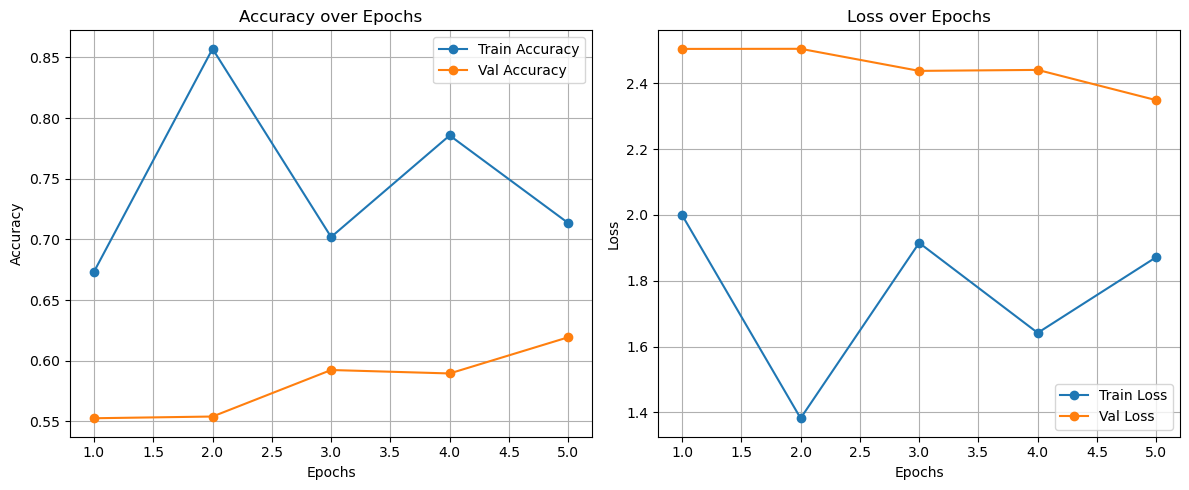


Epoch 5: val_loss improved from 2.43751 to 2.34848, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 172ms/step - accuracy: 0.5189 - auc: 0.7929 - loss: 2.3881 - precision_1: 0.6083 - recall_1: 0.4331 - val_accuracy: 0.6193 - val_auc: 0.8468 - val_loss: 2.3485 - val_precision_1: 0.6361 - val_recall_1: 0.5810 - learning_rate: 1.0000e-05
Epoch 6/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9286 - auc: 0.9885 - loss: 1.4628 - precision_1: 0.9231 - recall_1: 0.8571Epoch 6: Train Accuracy: 0.9286, Val Accuracy: 0.6193, Train Loss: 1.4628, Val Loss: 2.3482

Epoch 6: val_loss improved from 2.34848 to 2.34824, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9286 - auc: 0.9885 - loss: 1.4628 - precision_1: 0.9231 - recall_1: 0.8571 - val_accuracy: 0.6193 - val_auc: 0.8471 - val_loss: 2.3482 - val_precision_1: 0.6361 - val_recall_1: 0.5810 - learning_rate: 1.0000e-05
Epoch 7/100
95/95 ━━━━━━━━━━━━━━━━━━

2024-12-06 12:41:39.789754: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 7: Train Accuracy: 0.7247, Val Accuracy: 0.6364, Train Loss: 1.8374, Val Loss: 2.2762

Epoch 7: val_loss improved from 2.34824 to 2.27624, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - accuracy: 0.5266 - auc: 0.7946 - loss: 2.3595 - precision_1: 0.6187 - recall_1: 0.4445 - val_accuracy: 0.6364 - val_auc: 0.8547 - val_loss: 2.2762 - val_precision_1: 0.6567 - val_recall_1: 0.5923 - learning_rate: 1.0000e-05
Epoch 8/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9286 - auc: 0.9962 - loss: 1.3029 - precision_1: 0.9231 - recall_1: 0.8571Epoch 8: Train Accuracy: 0.9286, Val Accuracy: 0.6364, Train Loss: 1.3029, Val Loss: 2.2784

Epoch 8: val_loss did not improve from 2.27624
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9286 - auc: 0.9962 - loss: 1.3029 - precision_1: 0.9231 - recall_1: 0.8571 - val_accuracy: 0.6364 - val_auc: 0.8548 - val_loss: 2.2784 - val_precision_1: 0.6577 - val_recall_1: 0.5923 - learning_rate: 1.0000e

2024-12-06 12:41:57.698706: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 9: Train Accuracy: 0.7316, Val Accuracy: 0.6293, Train Loss: 1.8249, Val Loss: 2.2651

Epoch 9: val_loss improved from 2.27624 to 2.26507, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 166ms/step - accuracy: 0.5296 - auc: 0.7962 - loss: 2.3544 - precision_1: 0.6207 - recall_1: 0.4453 - val_accuracy: 0.6293 - val_auc: 0.8536 - val_loss: 2.2651 - val_precision_1: 0.6556 - val_recall_1: 0.5866 - learning_rate: 1.0000e-05
Epoch 10/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8571 - auc: 0.9834 - loss: 1.3787 - precision_1: 0.9231 - recall_1: 0.8571

2024-12-06 12:41:59.169463: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 10: Train Accuracy: 0.8571, Val Accuracy: 0.6293, Train Loss: 1.3787, Val Loss: 2.2659


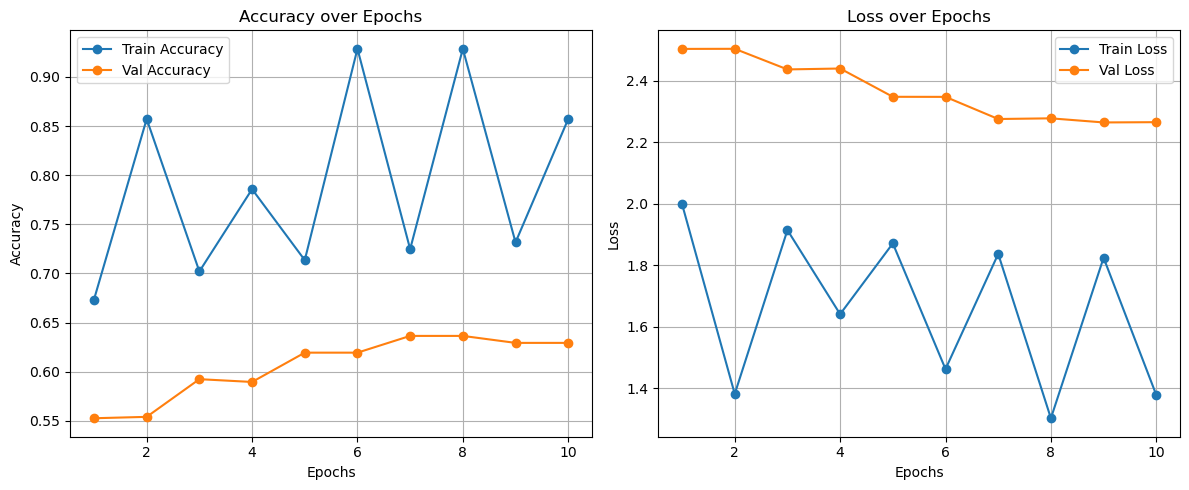


Epoch 10: val_loss did not improve from 2.26507
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8571 - auc: 0.9834 - loss: 1.3787 - precision_1: 0.9231 - recall_1: 0.8571 - val_accuracy: 0.6293 - val_auc: 0.8538 - val_loss: 2.2659 - val_precision_1: 0.6551 - val_recall_1: 0.5881 - learning_rate: 1.0000e-05
Epoch 11/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.5216 - auc: 0.7966 - loss: 2.3366 - precision_1: 0.6025 - recall_1: 0.4244

2024-12-06 12:42:14.916661: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 11: Train Accuracy: 0.7219, Val Accuracy: 0.6349, Train Loss: 1.8202, Val Loss: 2.2403

Epoch 11: val_loss improved from 2.26507 to 2.24026, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - accuracy: 0.5237 - auc: 0.7979 - loss: 2.3313 - precision_1: 0.6047 - recall_1: 0.4267 - val_accuracy: 0.6349 - val_auc: 0.8542 - val_loss: 2.2403 - val_precision_1: 0.6581 - val_recall_1: 0.5795 - learning_rate: 1.0000e-05
Epoch 12/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.2888 - precision_1: 1.0000 - recall_1: 0.9286

2024-12-06 12:42:16.363273: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Epoch 12: Train Accuracy: 1.0000, Val Accuracy: 0.6349, Train Loss: 1.2888, Val Loss: 2.2433

Epoch 12: val_loss did not improve from 2.24026
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.2888 - precision_1: 1.0000 - recall_1: 0.9286 - val_accuracy: 0.6349 - val_auc: 0.8532 - val_loss: 2.2433 - val_precision_1: 0.6570 - val_recall_1: 0.5767 - learning_rate: 1.0000e-05
Epoch 13/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.5393 - auc: 0.8021 - loss: 2.3047 - precision_1: 0.6230 - recall_1: 0.4529Epoch 13: Train Accuracy: 0.7393, Val Accuracy: 0.6207, Train Loss: 1.7899, Val Loss: 2.2598

Epoch 13: val_loss did not improve from 2.24026
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 0.5414 - auc: 0.8034 - loss: 2.2993 - precision_1: 0.6251 - recall_1: 0.4551 - val_accuracy: 0.6207 - val_auc: 0.8481 - val_loss: 2.2598 - val_precision_1: 0.6346 - val_recall_1: 0.5625 - learning_rate: 1.0000e-05
Epoch 14/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1

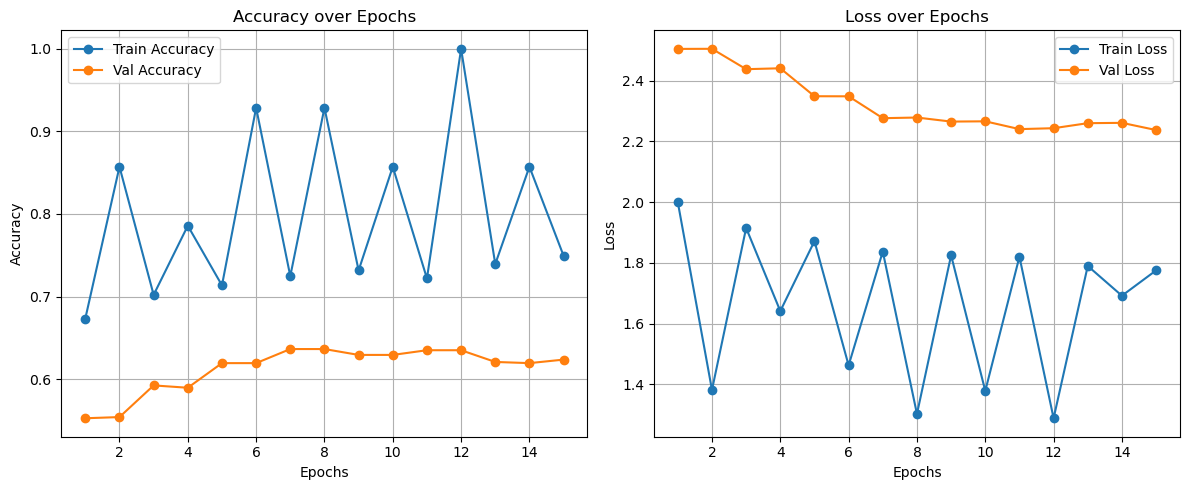


Epoch 15: val_loss improved from 2.24026 to 2.23723, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step - accuracy: 0.5542 - auc: 0.8059 - loss: 2.2889 - precision_1: 0.6447 - recall_1: 0.4684 - val_accuracy: 0.6236 - val_auc: 0.8506 - val_loss: 2.2372 - val_precision_1: 0.6406 - val_recall_1: 0.5696 - learning_rate: 2.0000e-06
Epoch 16/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7857 - auc: 0.9809 - loss: 1.4410 - precision_1: 0.9167 - recall_1: 0.7857Epoch 16: Train Accuracy: 0.7857, Val Accuracy: 0.6250, Train Loss: 1.4410, Val Loss: 2.2374

Epoch 16: val_loss did not improve from 2.23723
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7857 - auc: 0.9809 - loss: 1.4410 - precision_1: 0.9167 - recall_1: 0.7857 - val_accuracy: 0.6250 - val_auc: 0.8511 - val_loss: 2.2374 - val_precision_1: 0.6432 - val_recall_1: 0.5710 - learning_rate: 2.0000e-06
Epoch 17/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.5448 - auc: 0.80

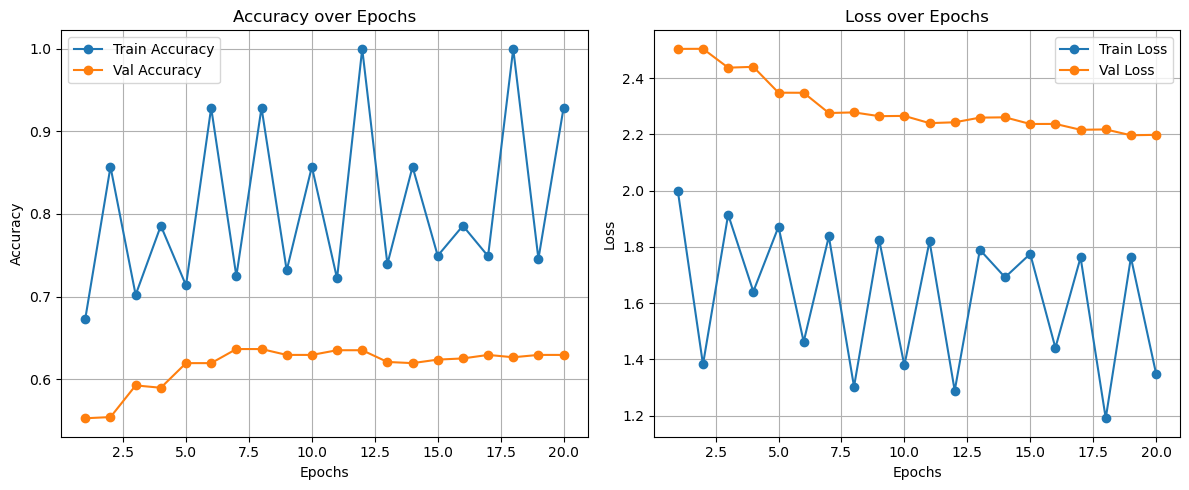


Epoch 20: val_loss did not improve from 2.19710
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9286 - auc: 0.9898 - loss: 1.3493 - precision_1: 0.9231 - recall_1: 0.8571 - val_accuracy: 0.6293 - val_auc: 0.8578 - val_loss: 2.1986 - val_precision_1: 0.6576 - val_recall_1: 0.5810 - learning_rate: 2.0000e-06
Epoch 21/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.5460 - auc: 0.8096 - loss: 2.2639 - precision_1: 0.6441 - recall_1: 0.4584Epoch 21: Train Accuracy: 0.7500, Val Accuracy: 0.6364, Train Loss: 1.7503, Val Loss: 2.1842

Epoch 21: val_loss improved from 2.19710 to 2.18421, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 179ms/step - accuracy: 0.5481 - auc: 0.8109 - loss: 2.2586 - precision_1: 0.6462 - recall_1: 0.4606 - val_accuracy: 0.6364 - val_auc: 0.8598 - val_loss: 2.1842 - val_precision_1: 0.6612 - val_recall_1: 0.5682 - learning_rate: 2.0000e-06
Epoch 22/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9286 - auc: 0.99

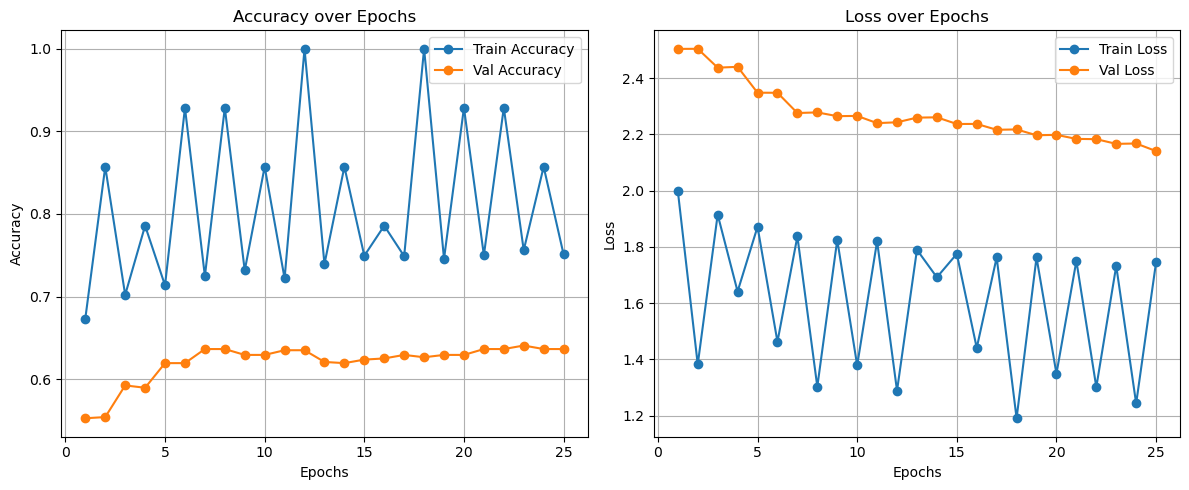


Epoch 25: val_loss improved from 2.16653 to 2.14084, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step - accuracy: 0.5601 - auc: 0.8115 - loss: 2.2432 - precision_1: 0.6512 - recall_1: 0.4700 - val_accuracy: 0.6364 - val_auc: 0.8670 - val_loss: 2.1408 - val_precision_1: 0.6784 - val_recall_1: 0.5753 - learning_rate: 2.0000e-06
Epoch 26/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8571 - auc: 0.9745 - loss: 1.4564 - precision_1: 0.9167 - recall_1: 0.7857Epoch 26: Train Accuracy: 0.8571, Val Accuracy: 0.6349, Train Loss: 1.4564, Val Loss: 2.1423

Epoch 26: val_loss did not improve from 2.14084
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8571 - auc: 0.9745 - loss: 1.4564 - precision_1: 0.9167 - recall_1: 0.7857 - val_accuracy: 0.6349 - val_auc: 0.8664 - val_loss: 2.1423 - val_precision_1: 0.6761 - val_recall_1: 0.5753 - learning_rate: 2.0000e-06
Epoch 27/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.5672 - auc: 0.81

2024-12-06 12:44:58.496905: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 29: Train Accuracy: 0.7421, Val Accuracy: 0.6335, Train Loss: 1.7515, Val Loss: 2.1162

Epoch 29: val_loss improved from 2.12955 to 2.11624, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - accuracy: 0.5351 - auc: 0.8024 - loss: 2.2779 - precision_1: 0.6272 - recall_1: 0.4549 - val_accuracy: 0.6335 - val_auc: 0.8698 - val_loss: 2.1162 - val_precision_1: 0.6807 - val_recall_1: 0.5724 - learning_rate: 2.0000e-06
Epoch 30/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.1863 - precision_1: 1.0000 - recall_1: 1.0000

2024-12-06 12:44:59.946063: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13783824471912782382
2024-12-06 12:44:59.946126: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 393123393767902732


Epoch 30: Train Accuracy: 1.0000, Val Accuracy: 0.6335, Train Loss: 1.1863, Val Loss: 2.1160


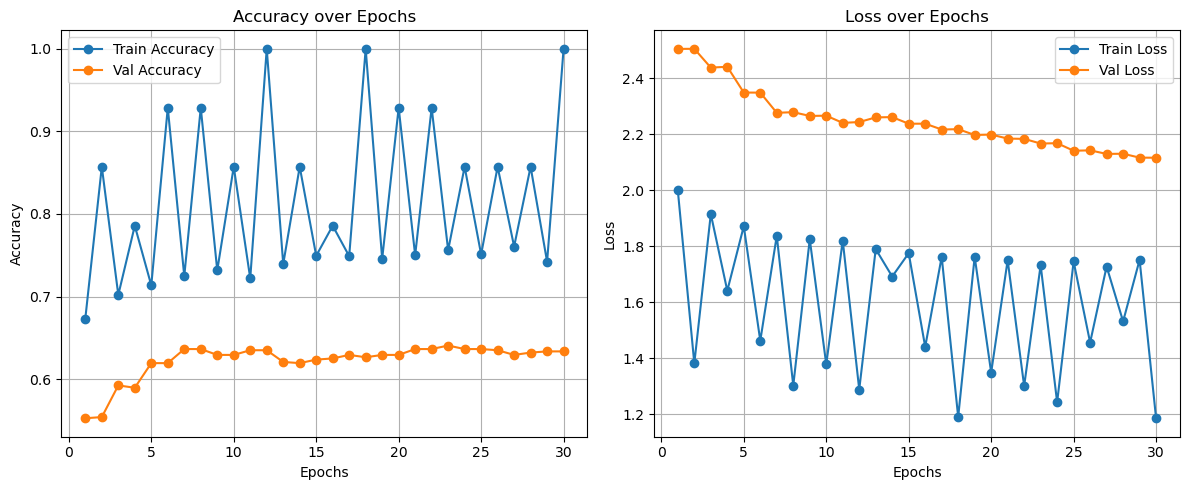


Epoch 30: val_loss improved from 2.11624 to 2.11597, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.1863 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 0.6335 - val_auc: 0.8700 - val_loss: 2.1160 - val_precision_1: 0.6791 - val_recall_1: 0.5710 - learning_rate: 2.0000e-06
Epoch 31/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.5560 - auc: 0.8118 - loss: 2.2348 - precision_1: 0.6455 - recall_1: 0.4715Epoch 31: Train Accuracy: 0.7581, Val Accuracy: 0.6378, Train Loss: 1.7279, Val Loss: 2.1005

Epoch 31: val_loss improved from 2.11597 to 2.10050, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 166ms/step - accuracy: 0.5581 - auc: 0.8131 - loss: 2.2295 - precision_1: 0.6476 - recall_1: 0.4738 - val_accuracy: 0.6378 - val_auc: 0.8737 - val_loss: 2.1005 - val_precision_1: 0.6763 - val_recall_1: 0.5668 - learning_rate: 2.0000e-06
Epoch 32/100
 1/95 ━━━━━━━━━━━━

2024-12-06 12:45:20.088430: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 32: Train Accuracy: 0.8571, Val Accuracy: 0.6378, Train Loss: 1.2606, Val Loss: 2.1015

Epoch 32: val_loss did not improve from 2.10050
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8571 - auc: 0.9923 - loss: 1.2606 - precision_1: 0.9231 - recall_1: 0.8571 - val_accuracy: 0.6378 - val_auc: 0.8737 - val_loss: 2.1015 - val_precision_1: 0.6751 - val_recall_1: 0.5668 - learning_rate: 2.0000e-06
Epoch 33/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.5570 - auc: 0.8107 - loss: 2.2525 - precision_1: 0.6390 - recall_1: 0.4646Epoch 33: Train Accuracy: 0.7556, Val Accuracy: 0.6477, Train Loss: 1.7475, Val Loss: 2.0904

Epoch 33: val_loss improved from 2.10050 to 2.09039, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - accuracy: 0.5590 - auc: 0.8120 - loss: 2.2472 - precision_1: 0.6410 - recall_1: 0.4668 - val_accuracy: 0.6477 - val_auc: 0.8755 - val_loss: 2.0904 - val_precision_1: 0.6941 - val_recall_1: 0.5866 - learning_rate: 2

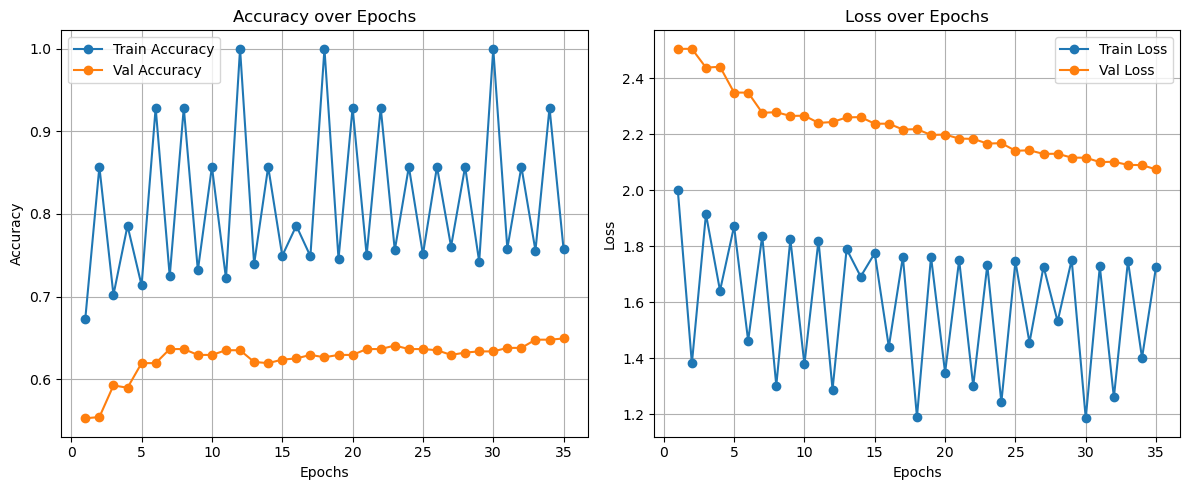


Epoch 35: val_loss improved from 2.08964 to 2.07416, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 168ms/step - accuracy: 0.5656 - auc: 0.8163 - loss: 2.2257 - precision_1: 0.6615 - recall_1: 0.4706 - val_accuracy: 0.6491 - val_auc: 0.8783 - val_loss: 2.0742 - val_precision_1: 0.6975 - val_recall_1: 0.5895 - learning_rate: 2.0000e-06
Epoch 36/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6429 - auc: 0.8705 - loss: 2.2209 - precision_1: 0.6667 - recall_1: 0.5714Epoch 36: Train Accuracy: 0.6429, Val Accuracy: 0.6506, Train Loss: 2.2209, Val Loss: 2.0775

Epoch 36: val_loss did not improve from 2.07416
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6429 - auc: 0.8705 - loss: 2.2209 - precision_1: 0.6667 - recall_1: 0.5714 - val_accuracy: 0.6506 - val_auc: 0.8777 - val_loss: 2.0775 - val_precision_1: 0.6914 - val_recall_1: 0.5824 - learning_rate: 2.0000e-06
Epoch 37/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5418 - auc: 0.81

2024-12-06 12:46:29.989991: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 39: Train Accuracy: 0.7581, Val Accuracy: 0.6577, Train Loss: 1.7084, Val Loss: 2.0469

Epoch 39: val_loss improved from 2.05818 to 2.04692, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step - accuracy: 0.5649 - auc: 0.8170 - loss: 2.2029 - precision_1: 0.6523 - recall_1: 0.4694 - val_accuracy: 0.6577 - val_auc: 0.8832 - val_loss: 2.0469 - val_precision_1: 0.7010 - val_recall_1: 0.5994 - learning_rate: 2.0000e-06
Epoch 40/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.1313 - precision_1: 1.0000 - recall_1: 1.0000Epoch 40: Train Accuracy: 1.0000, Val Accuracy: 0.6605, Train Loss: 1.1313, Val Loss: 2.0468


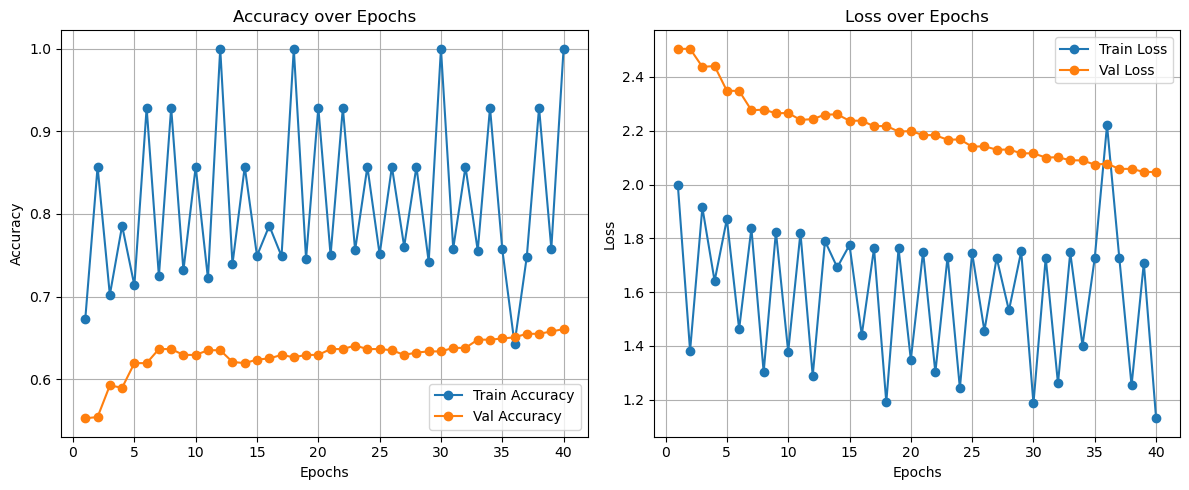


Epoch 40: val_loss improved from 2.04692 to 2.04679, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.1313 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 0.6605 - val_auc: 0.8833 - val_loss: 2.0468 - val_precision_1: 0.7015 - val_recall_1: 0.6009 - learning_rate: 2.0000e-06
Epoch 41/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.5624 - auc: 0.8150 - loss: 2.2247 - precision_1: 0.6508 - recall_1: 0.4688Epoch 41: Train Accuracy: 0.7605, Val Accuracy: 0.6648, Train Loss: 1.7115, Val Loss: 2.0227

Epoch 41: val_loss improved from 2.04679 to 2.02273, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 178ms/step - accuracy: 0.5645 - auc: 0.8163 - loss: 2.2194 - precision_1: 0.6529 - recall_1: 0.4711 - val_accuracy: 0.6648 - val_auc: 0.8881 - val_loss: 2.0227 - val_precision_1: 0.7159 - val_recall_1: 0.6122 - learning_rate: 2.0000e-06
Epoch 42/100
 1/95 ━━━━━━━━━━━━

2024-12-06 12:47:09.156607: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 44: Train Accuracy: 0.7857, Val Accuracy: 0.6690, Train Loss: 1.8607, Val Loss: 2.0135

Epoch 44: val_loss did not improve from 2.01241
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7857 - auc: 0.9069 - loss: 1.8607 - precision_1: 0.7273 - recall_1: 0.5714 - val_accuracy: 0.6690 - val_auc: 0.8899 - val_loss: 2.0135 - val_precision_1: 0.7112 - val_recall_1: 0.6051 - learning_rate: 2.0000e-06
Epoch 45/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.5553 - auc: 0.8181 - loss: 2.2139 - precision_1: 0.6464 - recall_1: 0.4638Epoch 45: Train Accuracy: 0.7572, Val Accuracy: 0.6832, Train Loss: 1.7117, Val Loss: 1.9915


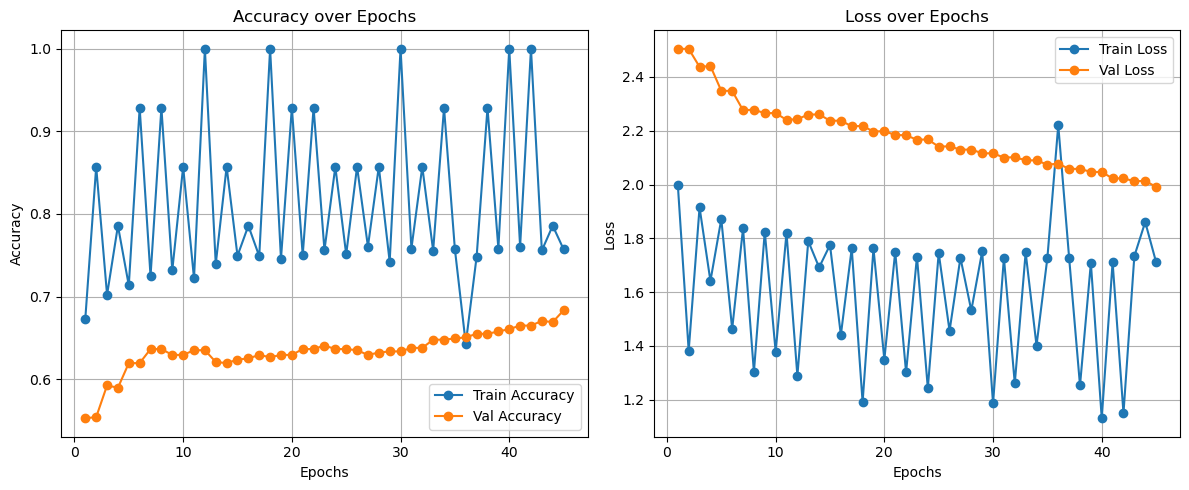


Epoch 45: val_loss improved from 2.01241 to 1.99147, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step - accuracy: 0.5574 - auc: 0.8194 - loss: 2.2087 - precision_1: 0.6485 - recall_1: 0.4662 - val_accuracy: 0.6832 - val_auc: 0.8939 - val_loss: 1.9915 - val_precision_1: 0.7235 - val_recall_1: 0.6207 - learning_rate: 2.0000e-06
Epoch 46/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.2290 - precision_1: 1.0000 - recall_1: 0.9286Epoch 46: Train Accuracy: 1.0000, Val Accuracy: 0.6832, Train Loss: 1.2290, Val Loss: 1.9916

Epoch 46: val_loss did not improve from 1.99147
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.2290 - precision_1: 1.0000 - recall_1: 0.9286 - val_accuracy: 0.6832 - val_auc: 0.8939 - val_loss: 1.9916 - val_precision_1: 0.7223 - val_recall_1: 0.6207 - learning_rate: 2.0000e-06
Epoch 47/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.5690 - auc: 0.8

2024-12-06 12:47:44.166335: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 47: Train Accuracy: 0.7694, Val Accuracy: 0.6903, Train Loss: 1.6929, Val Loss: 1.9744

Epoch 47: val_loss improved from 1.99147 to 1.97437, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 169ms/step - accuracy: 0.5711 - auc: 0.8194 - loss: 2.2042 - precision_1: 0.6546 - recall_1: 0.4780 - val_accuracy: 0.6903 - val_auc: 0.8967 - val_loss: 1.9744 - val_precision_1: 0.7337 - val_recall_1: 0.6222 - learning_rate: 2.0000e-06
Epoch 48/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7143 - auc: 0.9605 - loss: 1.5963 - precision_1: 0.9091 - recall_1: 0.7143

2024-12-06 12:47:45.688210: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 48: Train Accuracy: 0.7143, Val Accuracy: 0.6918, Train Loss: 1.5963, Val Loss: 1.9740

Epoch 48: val_loss improved from 1.97437 to 1.97398, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7143 - auc: 0.9605 - loss: 1.5963 - precision_1: 0.9091 - recall_1: 0.7143 - val_accuracy: 0.6918 - val_auc: 0.8966 - val_loss: 1.9740 - val_precision_1: 0.7370 - val_recall_1: 0.6250 - learning_rate: 2.0000e-06
Epoch 49/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.5685 - auc: 0.8234 - loss: 2.1751 - precision_1: 0.6648 - recall_1: 0.4778Epoch 49: Train Accuracy: 0.7681, Val Accuracy: 0.7045, Train Loss: 1.6796, Val Loss: 1.9521

Epoch 49: val_loss improved from 1.97398 to 1.95215, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 179ms/step - accuracy: 0.5706 - auc: 0.8246 - loss: 2.1700 - precision_1: 0.6668 - recall_1: 0.4801 - val_accuracy: 0.7045 - val_auc: 0.9002 - val_loss: 1.9521 - val_precision

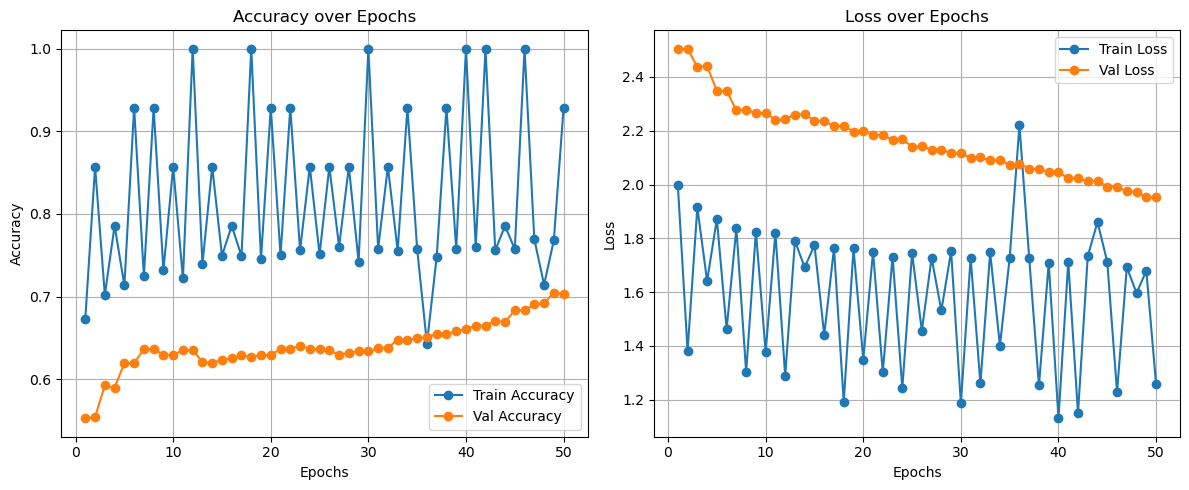


Epoch 50: val_loss did not improve from 1.95215
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9286 - auc: 0.9962 - loss: 1.2579 - precision_1: 1.0000 - recall_1: 0.9286 - val_accuracy: 0.7031 - val_auc: 0.9003 - val_loss: 1.9526 - val_precision_1: 0.7479 - val_recall_1: 0.6278 - learning_rate: 2.0000e-06
Epoch 51/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.5618 - auc: 0.8160 - loss: 2.2105 - precision_1: 0.6453 - recall_1: 0.4726Epoch 51: Train Accuracy: 0.7655, Val Accuracy: 0.7116, Train Loss: 1.7003, Val Loss: 1.9377

Epoch 51: val_loss improved from 1.95215 to 1.93770, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step - accuracy: 0.5639 - auc: 0.8173 - loss: 2.2052 - precision_1: 0.6474 - recall_1: 0.4749 - val_accuracy: 0.7116 - val_auc: 0.9031 - val_loss: 1.9377 - val_precision_1: 0.7546 - val_recall_1: 0.6378 - learning_rate: 2.0000e-06
Epoch 52/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8571 - auc: 0.98

2024-12-06 12:48:39.916979: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 53: Train Accuracy: 0.7625, Val Accuracy: 0.7188, Train Loss: 1.6931, Val Loss: 1.9236

Epoch 53: val_loss improved from 1.93770 to 1.92355, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 170ms/step - accuracy: 0.5554 - auc: 0.8168 - loss: 2.2034 - precision_1: 0.6498 - recall_1: 0.4731 - val_accuracy: 0.7188 - val_auc: 0.9052 - val_loss: 1.9236 - val_precision_1: 0.7609 - val_recall_1: 0.6420 - learning_rate: 2.0000e-06
Epoch 54/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.1079 - precision_1: 1.0000 - recall_1: 1.0000Epoch 54: Train Accuracy: 1.0000, Val Accuracy: 0.7188, Train Loss: 1.1079, Val Loss: 1.9244

Epoch 54: val_loss did not improve from 1.92355
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.1079 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 0.7188 - val_auc: 0.9053 - val_loss: 1.9244 - val_precision_1: 0.7605 - val_recall_1: 0.6406 - learning_rate: 2.

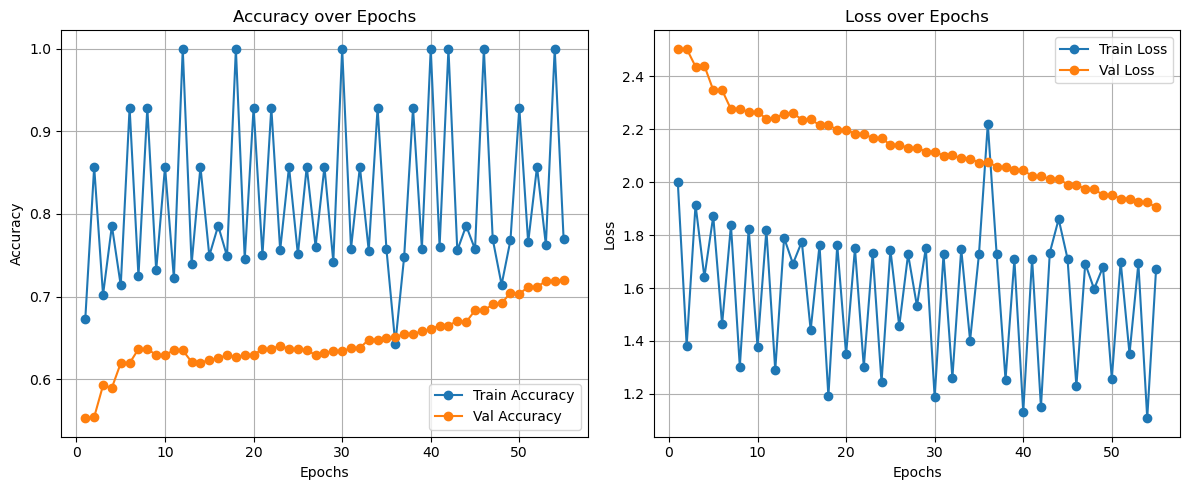


Epoch 55: val_loss improved from 1.92355 to 1.90569, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 182ms/step - accuracy: 0.5777 - auc: 0.8283 - loss: 2.1484 - precision_1: 0.6625 - recall_1: 0.4906 - val_accuracy: 0.7202 - val_auc: 0.9077 - val_loss: 1.9057 - val_precision_1: 0.7750 - val_recall_1: 0.6506 - learning_rate: 2.0000e-06
Epoch 56/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7143 - auc: 0.9496 - loss: 1.6633 - precision_1: 0.7500 - recall_1: 0.6429

2024-12-06 12:49:00.474116: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13783824471912782382
2024-12-06 12:49:00.474173: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 393123393767902732
2024-12-06 12:49:00.567417: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 56: Train Accuracy: 0.7143, Val Accuracy: 0.7202, Train Loss: 1.6633, Val Loss: 1.9059

Epoch 56: val_loss did not improve from 1.90569
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7143 - auc: 0.9496 - loss: 1.6633 - precision_1: 0.7500 - recall_1: 0.6429 - val_accuracy: 0.7202 - val_auc: 0.9077 - val_loss: 1.9059 - val_precision_1: 0.7759 - val_recall_1: 0.6491 - learning_rate: 2.0000e-06
Epoch 57/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.5618 - auc: 0.8177 - loss: 2.1940 - precision_1: 0.6567 - recall_1: 0.4749Epoch 57: Train Accuracy: 0.7628, Val Accuracy: 0.7244, Train Loss: 1.6957, Val Loss: 1.8834

Epoch 57: val_loss improved from 1.90569 to 1.88341, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 172ms/step - accuracy: 0.5639 - auc: 0.8190 - loss: 2.1888 - precision_1: 0.6587 - recall_1: 0.4772 - val_accuracy: 0.7244 - val_auc: 0.9113 - val_loss: 1.8834 - val_precision_1: 0.7780 - val_recall_1: 0.6619 - learning_rate: 2

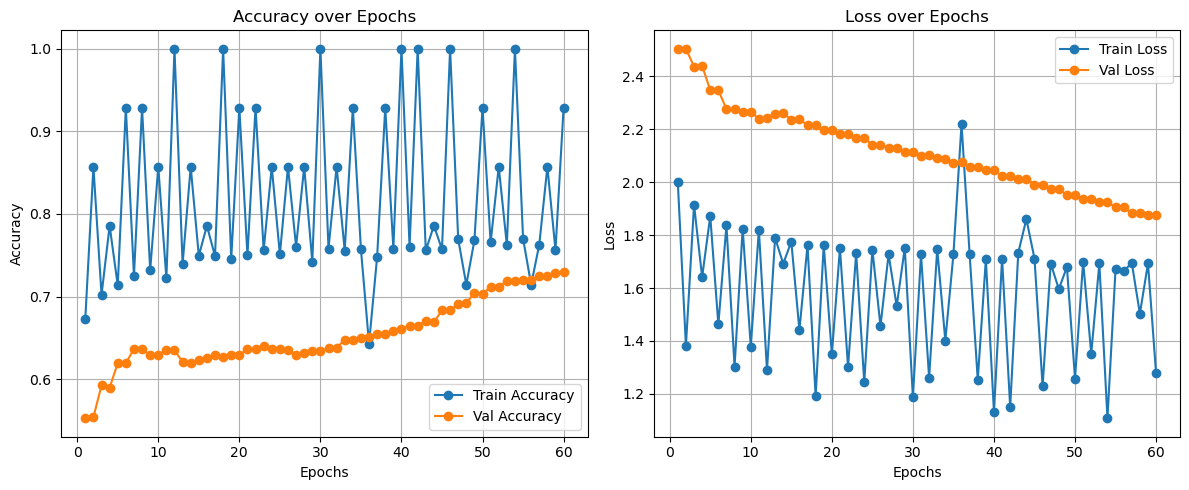


Epoch 60: val_loss did not improve from 1.87716
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9286 - auc: 0.9949 - loss: 1.2773 - precision_1: 0.9231 - recall_1: 0.8571 - val_accuracy: 0.7301 - val_auc: 0.9128 - val_loss: 1.8779 - val_precision_1: 0.7831 - val_recall_1: 0.6719 - learning_rate: 2.0000e-06
Epoch 61/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.5761 - auc: 0.8281 - loss: 2.1508 - precision_1: 0.6748 - recall_1: 0.4887Epoch 61: Train Accuracy: 0.7673, Val Accuracy: 0.7401, Train Loss: 1.6728, Val Loss: 1.8697

Epoch 61: val_loss improved from 1.87716 to 1.86966, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 173ms/step - accuracy: 0.5781 - auc: 0.8293 - loss: 2.1458 - precision_1: 0.6766 - recall_1: 0.4909 - val_accuracy: 0.7401 - val_auc: 0.9139 - val_loss: 1.8697 - val_precision_1: 0.7816 - val_recall_1: 0.6861 - learning_rate: 2.0000e-06
Epoch 62/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7143 - auc: 0.9

2024-12-06 12:49:55.621828: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 62: Train Accuracy: 0.7143, Val Accuracy: 0.7429, Train Loss: 1.4548, Val Loss: 1.8688

Epoch 62: val_loss improved from 1.86966 to 1.86881, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7143 - auc: 0.9770 - loss: 1.4548 - precision_1: 0.9091 - recall_1: 0.7143 - val_accuracy: 0.7429 - val_auc: 0.9141 - val_loss: 1.8688 - val_precision_1: 0.7830 - val_recall_1: 0.6918 - learning_rate: 2.0000e-06
Epoch 63/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.5666 - auc: 0.8177 - loss: 2.1949 - precision_1: 0.6547 - recall_1: 0.4710Epoch 63: Train Accuracy: 0.7633, Val Accuracy: 0.7429, Train Loss: 1.6945, Val Loss: 1.8659

Epoch 63: val_loss improved from 1.86881 to 1.86588, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 172ms/step - accuracy: 0.5686 - auc: 0.8190 - loss: 2.1897 - precision_1: 0.6567 - recall_1: 0.4733 - val_accuracy: 0.7429 - val_auc: 0.9145 - val_loss: 1.8659 - val_precision

2024-12-06 12:50:14.543333: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 64: Train Accuracy: 0.9286, Val Accuracy: 0.7429, Train Loss: 1.2976, Val Loss: 1.8658

Epoch 64: val_loss improved from 1.86588 to 1.86583, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9286 - auc: 0.9911 - loss: 1.2976 - precision_1: 0.9231 - recall_1: 0.8571 - val_accuracy: 0.7429 - val_auc: 0.9146 - val_loss: 1.8658 - val_precision_1: 0.7819 - val_recall_1: 0.6875 - learning_rate: 2.0000e-06
Epoch 65/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.5683 - auc: 0.8207 - loss: 2.1790 - precision_1: 0.6614 - recall_1: 0.4787Epoch 65: Train Accuracy: 0.7696, Val Accuracy: 0.7543, Train Loss: 1.6726, Val Loss: 1.8545


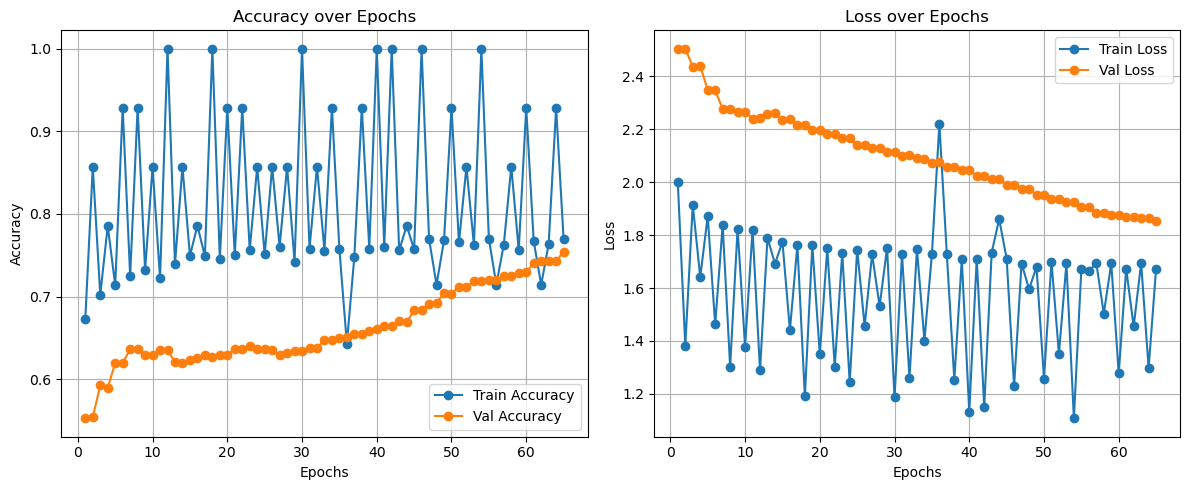


Epoch 65: val_loss improved from 1.86583 to 1.85450, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 175ms/step - accuracy: 0.5704 - auc: 0.8220 - loss: 2.1737 - precision_1: 0.6634 - recall_1: 0.4811 - val_accuracy: 0.7543 - val_auc: 0.9165 - val_loss: 1.8545 - val_precision_1: 0.7856 - val_recall_1: 0.6974 - learning_rate: 2.0000e-06
Epoch 66/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8571 - auc: 0.9847 - loss: 1.3569 - precision_1: 0.9231 - recall_1: 0.8571Epoch 66: Train Accuracy: 0.8571, Val Accuracy: 0.7528, Train Loss: 1.3569, Val Loss: 1.8548

Epoch 66: val_loss did not improve from 1.85450
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8571 - auc: 0.9847 - loss: 1.3569 - precision_1: 0.9231 - recall_1: 0.8571 - val_accuracy: 0.7528 - val_auc: 0.9166 - val_loss: 1.8548 - val_precision_1: 0.7859 - val_recall_1: 0.6989 - learning_rate: 2.0000e-06
Epoch 67/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.5742 - auc: 0.82

2024-12-06 12:51:10.752887: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13783824471912782382
2024-12-06 12:51:10.752941: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 393123393767902732


Epoch 70: Train Accuracy: 0.9286, Val Accuracy: 0.7443, Train Loss: 1.1664, Val Loss: 1.8499


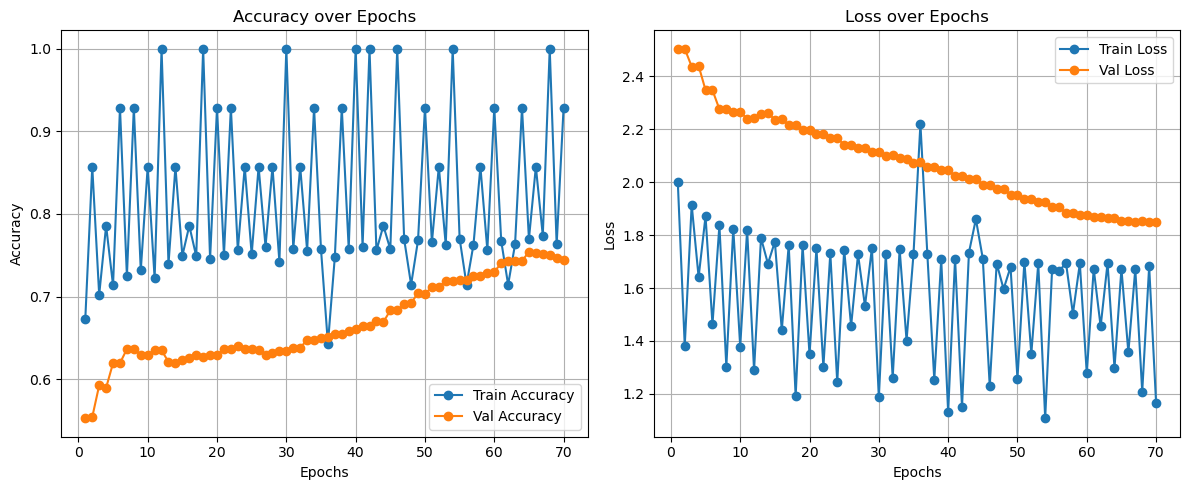


Epoch 70: val_loss did not improve from 1.84891
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9286 - auc: 0.9987 - loss: 1.1664 - precision_1: 0.9286 - recall_1: 0.9286 - val_accuracy: 0.7443 - val_auc: 0.9168 - val_loss: 1.8499 - val_precision_1: 0.7830 - val_recall_1: 0.6918 - learning_rate: 2.0000e-06
Epoch 71/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.5832 - auc: 0.8285 - loss: 2.1390 - precision_1: 0.6818 - recall_1: 0.4914Epoch 71: Train Accuracy: 0.7793, Val Accuracy: 0.7457, Train Loss: 1.6523, Val Loss: 1.8400

Epoch 71: val_loss improved from 1.84891 to 1.83995, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 181ms/step - accuracy: 0.5853 - auc: 0.8297 - loss: 2.1339 - precision_1: 0.6837 - recall_1: 0.4937 - val_accuracy: 0.7457 - val_auc: 0.9185 - val_loss: 1.8400 - val_precision_1: 0.7781 - val_recall_1: 0.6875 - learning_rate: 2.0000e-06
Epoch 72/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8571 - auc: 0.9

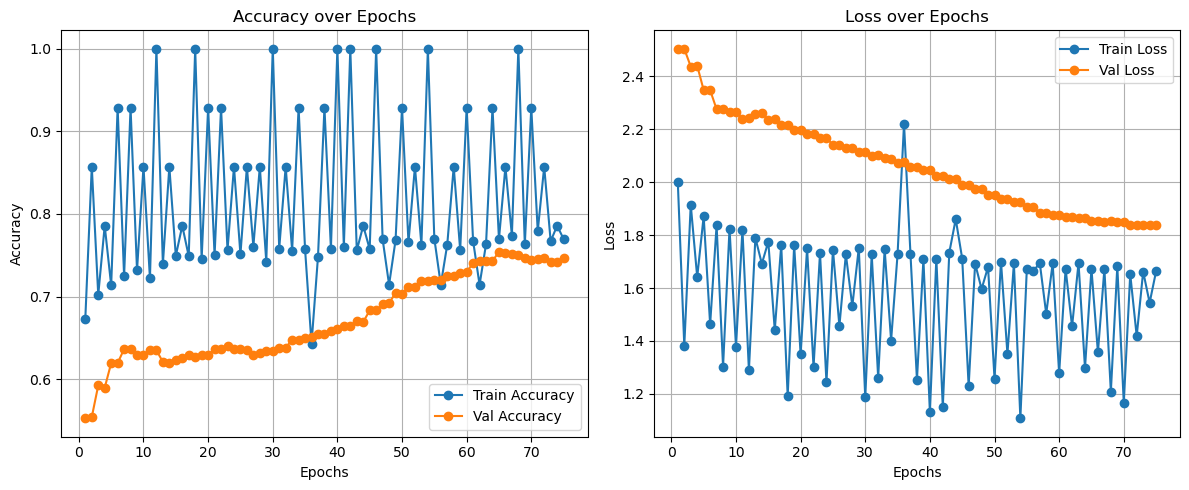


Epoch 75: val_loss improved from 1.83865 to 1.83794, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 182ms/step - accuracy: 0.5773 - auc: 0.8250 - loss: 2.1524 - precision_1: 0.6626 - recall_1: 0.4788 - val_accuracy: 0.7472 - val_auc: 0.9184 - val_loss: 1.8379 - val_precision_1: 0.7781 - val_recall_1: 0.6875 - learning_rate: 2.0000e-06
Epoch 76/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9286 - auc: 0.9923 - loss: 1.3606 - precision_1: 0.9167 - recall_1: 0.7857

2024-12-06 12:52:09.238175: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Epoch 76: Train Accuracy: 0.9286, Val Accuracy: 0.7472, Train Loss: 1.3606, Val Loss: 1.8377

Epoch 76: val_loss improved from 1.83794 to 1.83773, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9286 - auc: 0.9923 - loss: 1.3606 - precision_1: 0.9167 - recall_1: 0.7857 - val_accuracy: 0.7472 - val_auc: 0.9186 - val_loss: 1.8377 - val_precision_1: 0.7783 - val_recall_1: 0.6832 - learning_rate: 2.0000e-06
Epoch 77/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.5890 - auc: 0.8318 - loss: 2.1235 - precision_1: 0.6791 - recall_1: 0.4975Epoch 77: Train Accuracy: 0.7859, Val Accuracy: 0.7457, Train Loss: 1.6322, Val Loss: 1.8327

Epoch 77: val_loss improved from 1.83773 to 1.83266, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 178ms/step - accuracy: 0.5911 - auc: 0.8330 - loss: 2.1184 - precision_1: 0.6811 - recall_1: 0.4998 - val_accuracy: 0.7457 - val_auc: 0.9193 - val_loss: 1.8327 - val_precision

2024-12-06 12:52:46.428380: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 79: Train Accuracy: 0.7740, Val Accuracy: 0.7514, Train Loss: 1.6573, Val Loss: 1.8198

Epoch 79: val_loss improved from 1.83259 to 1.81985, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 178ms/step - accuracy: 0.5748 - auc: 0.8234 - loss: 2.1513 - precision_1: 0.6647 - recall_1: 0.4860 - val_accuracy: 0.7514 - val_auc: 0.9214 - val_loss: 1.8198 - val_precision_1: 0.7772 - val_recall_1: 0.6889 - learning_rate: 2.0000e-06
Epoch 80/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9286 - auc: 0.9987 - loss: 1.2055 - precision_1: 0.9286 - recall_1: 0.9286Epoch 80: Train Accuracy: 0.9286, Val Accuracy: 0.7486, Train Loss: 1.2055, Val Loss: 1.8202


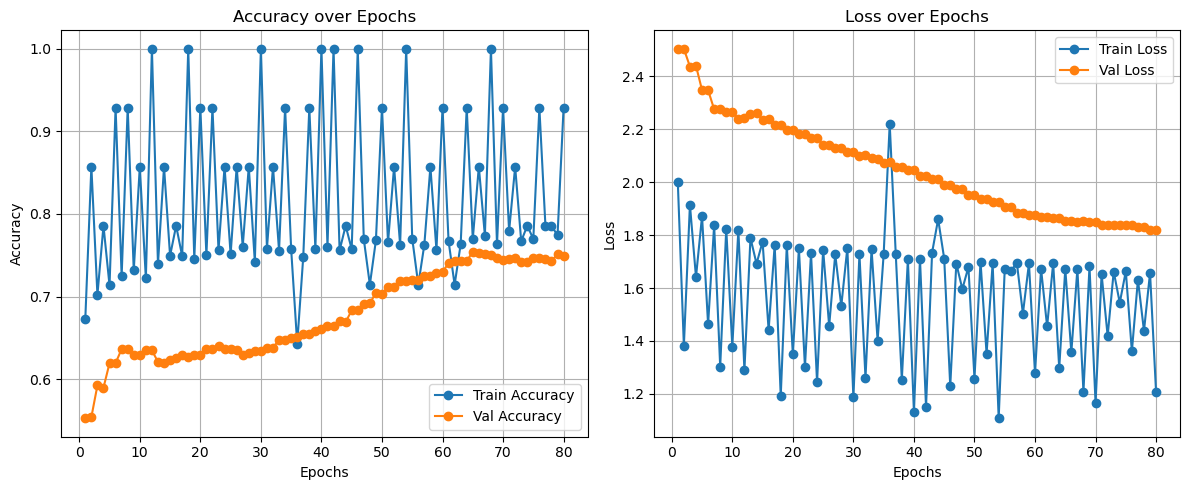


Epoch 80: val_loss did not improve from 1.81985
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9286 - auc: 0.9987 - loss: 1.2055 - precision_1: 0.9286 - recall_1: 0.9286 - val_accuracy: 0.7486 - val_auc: 0.9217 - val_loss: 1.8202 - val_precision_1: 0.7756 - val_recall_1: 0.6875 - learning_rate: 2.0000e-06
Epoch 81/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.5845 - auc: 0.8308 - loss: 2.1267 - precision_1: 0.6809 - recall_1: 0.4984Epoch 81: Train Accuracy: 0.7791, Val Accuracy: 0.7457, Train Loss: 1.6368, Val Loss: 1.8162

Epoch 81: val_loss improved from 1.81985 to 1.81622, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 180ms/step - accuracy: 0.5866 - auc: 0.8321 - loss: 2.1216 - precision_1: 0.6828 - recall_1: 0.5006 - val_accuracy: 0.7457 - val_auc: 0.9217 - val_loss: 1.8162 - val_precision_1: 0.7785 - val_recall_1: 0.6889 - learning_rate: 2.0000e-06
Epoch 82/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7857 - auc: 0.9

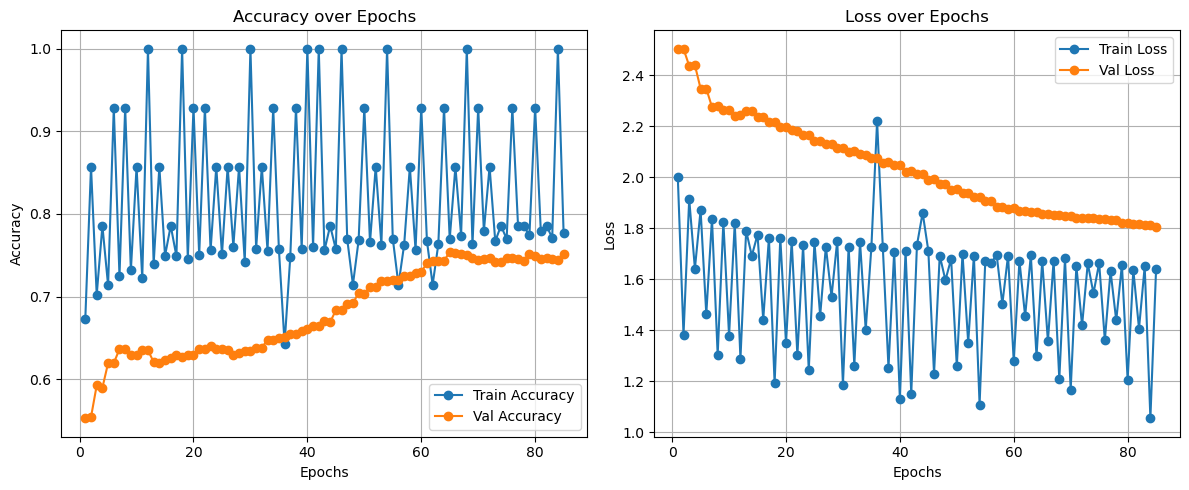


Epoch 85: val_loss improved from 1.81293 to 1.80697, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 186ms/step - accuracy: 0.5750 - auc: 0.8252 - loss: 2.1449 - precision_1: 0.6489 - recall_1: 0.4860 - val_accuracy: 0.7514 - val_auc: 0.9229 - val_loss: 1.8070 - val_precision_1: 0.7848 - val_recall_1: 0.6889 - learning_rate: 2.0000e-06
Epoch 86/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8571 - auc: 0.9923 - loss: 1.2538 - precision_1: 0.9231 - recall_1: 0.8571Epoch 86: Train Accuracy: 0.8571, Val Accuracy: 0.7528, Train Loss: 1.2538, Val Loss: 1.8070

Epoch 86: val_loss improved from 1.80697 to 1.80696, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8571 - auc: 0.9923 - loss: 1.2538 - precision_1: 0.9231 - recall_1: 0.8571 - val_accuracy: 0.7528 - val_auc: 0.9228 - val_loss: 1.8070 - val_precision_1: 0.7823 - val_recall_1: 0.6889 - learning_rate: 2.0000e-06
Epoch 87/100
95/95 ━━━━━━━━━━━━━

2024-12-06 12:54:34.104309: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13783824471912782382
2024-12-06 12:54:34.104405: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 393123393767902732


Epoch 90: Train Accuracy: 0.7143, Val Accuracy: 0.7443, Train Loss: 1.4791, Val Loss: 1.7993


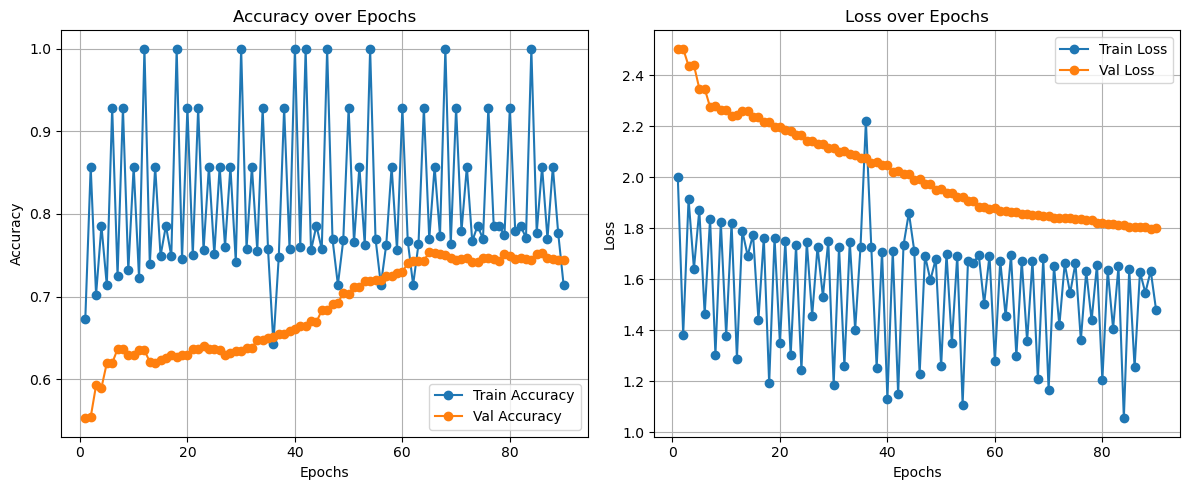


Epoch 90: val_loss did not improve from 1.79915
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7143 - auc: 0.9681 - loss: 1.4791 - precision_1: 0.8182 - recall_1: 0.6429 - val_accuracy: 0.7443 - val_auc: 0.9239 - val_loss: 1.7993 - val_precision_1: 0.7900 - val_recall_1: 0.6946 - learning_rate: 2.0000e-06
Epoch 91/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.5836 - auc: 0.8273 - loss: 2.1297 - precision_1: 0.6801 - recall_1: 0.4866Epoch 91: Train Accuracy: 0.7747, Val Accuracy: 0.7486, Train Loss: 1.6365, Val Loss: 1.7952

Epoch 91: val_loss improved from 1.79915 to 1.79522, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 181ms/step - accuracy: 0.5856 - auc: 0.8285 - loss: 2.1246 - precision_1: 0.6820 - recall_1: 0.4888 - val_accuracy: 0.7486 - val_auc: 0.9243 - val_loss: 1.7952 - val_precision_1: 0.7929 - val_recall_1: 0.6960 - learning_rate: 2.0000e-06
Epoch 92/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8571 - auc: 0.9

2024-12-06 12:54:53.432962: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 92: Train Accuracy: 0.8571, Val Accuracy: 0.7500, Train Loss: 1.4908, Val Loss: 1.7954

Epoch 92: val_loss did not improve from 1.79522
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8571 - auc: 0.9707 - loss: 1.4908 - precision_1: 0.9167 - recall_1: 0.7857 - val_accuracy: 0.7500 - val_auc: 0.9243 - val_loss: 1.7954 - val_precision_1: 0.7925 - val_recall_1: 0.6946 - learning_rate: 2.0000e-06
Epoch 93/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.5801 - auc: 0.8315 - loss: 2.1078 - precision_1: 0.6665 - recall_1: 0.4862Epoch 93: Train Accuracy: 0.7762, Val Accuracy: 0.7486, Train Loss: 1.6214, Val Loss: 1.7923

Epoch 93: val_loss improved from 1.79522 to 1.79230, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 181ms/step - accuracy: 0.5821 - auc: 0.8327 - loss: 2.1027 - precision_1: 0.6685 - recall_1: 0.4885 - val_accuracy: 0.7486 - val_auc: 0.9245 - val_loss: 1.7923 - val_precision_1: 0.7928 - val_recall_1: 0.6903 - learning_rate: 2

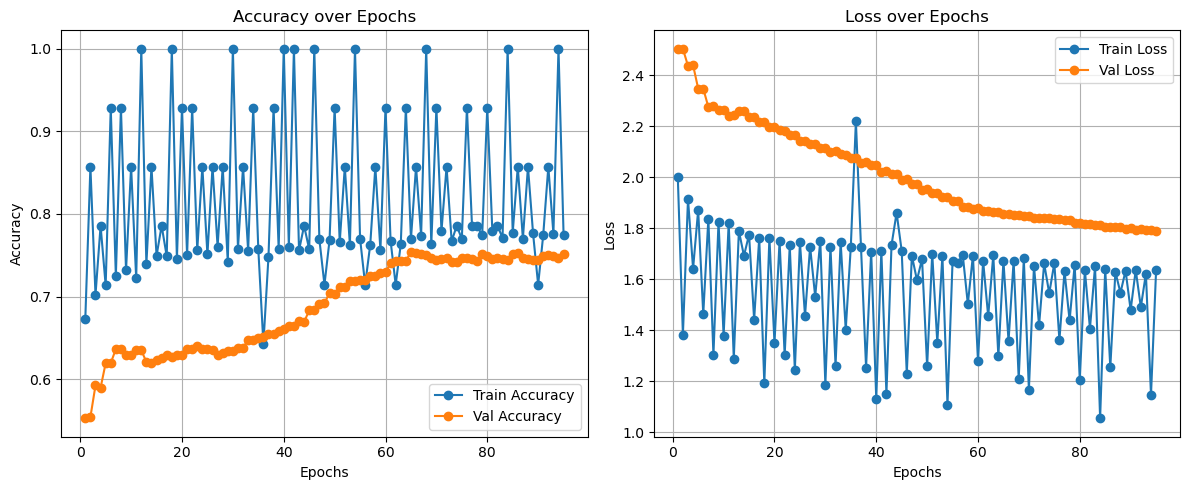


Epoch 95: val_loss improved from 1.79230 to 1.79074, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 28s 283ms/step - accuracy: 0.5772 - auc: 0.8230 - loss: 2.1372 - precision_1: 0.6691 - recall_1: 0.4966 - val_accuracy: 0.7514 - val_auc: 0.9248 - val_loss: 1.7907 - val_precision_1: 0.7893 - val_recall_1: 0.6918 - learning_rate: 2.0000e-06
Epoch 96/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9286 - auc: 0.9962 - loss: 1.2193 - precision_1: 0.9286 - recall_1: 0.9286Epoch 96: Train Accuracy: 0.9286, Val Accuracy: 0.7514, Train Loss: 1.2193, Val Loss: 1.7909

Epoch 96: val_loss did not improve from 1.79074
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9286 - auc: 0.9962 - loss: 1.2193 - precision_1: 0.9286 - recall_1: 0.9286 - val_accuracy: 0.7514 - val_auc: 0.9248 - val_loss: 1.7909 - val_precision_1: 0.7909 - val_recall_1: 0.6932 - learning_rate: 2.0000e-06
Epoch 97/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5727 - auc: 0.82

2024-12-06 12:56:01.528384: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 98: Train Accuracy: 0.9286, Val Accuracy: 0.7514, Train Loss: 1.1407, Val Loss: 1.7881

Epoch 98: val_loss did not improve from 1.78728
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9286 - auc: 0.9987 - loss: 1.1407 - precision_1: 0.9286 - recall_1: 0.9286 - val_accuracy: 0.7514 - val_auc: 0.9252 - val_loss: 1.7881 - val_precision_1: 0.7961 - val_recall_1: 0.6989 - learning_rate: 2.0000e-06
Epoch 99/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.5817 - auc: 0.8296 - loss: 2.1102 - precision_1: 0.6764 - recall_1: 0.4967Epoch 99: Train Accuracy: 0.7821, Val Accuracy: 0.7543, Train Loss: 1.6209, Val Loss: 1.7844

Epoch 99: val_loss improved from 1.78728 to 1.78435, saving model to best_model_preprocessed.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - accuracy: 0.5838 - auc: 0.8309 - loss: 2.1051 - precision_1: 0.6784 - recall_1: 0.4990 - val_accuracy: 0.7543 - val_auc: 0.9253 - val_loss: 1.7844 - val_precision_1: 0.8085 - val_recall_1: 0.7017 - learning_rate: 2

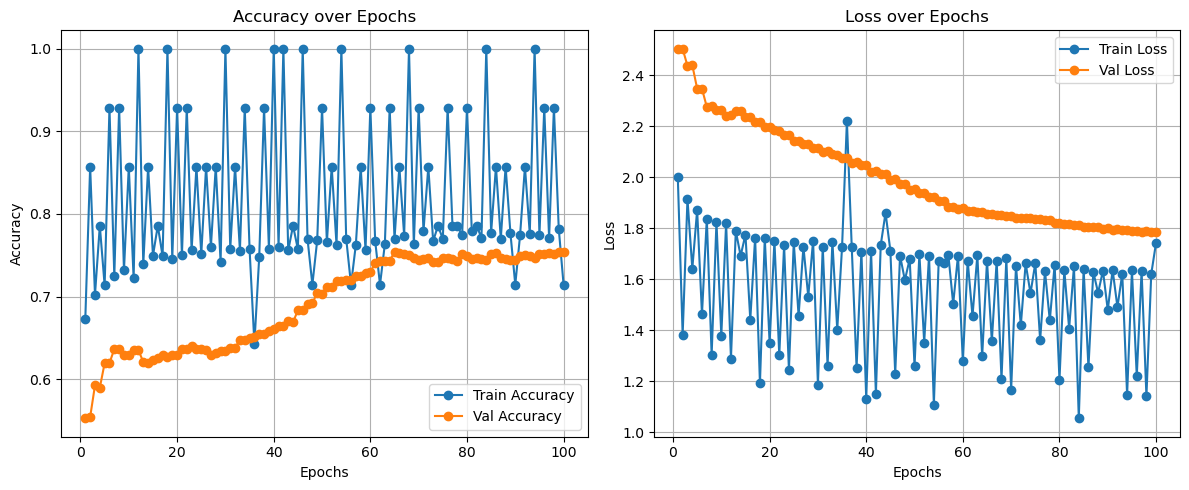


Epoch 100: val_loss did not improve from 1.78435
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7143 - auc: 0.9267 - loss: 1.7441 - precision_1: 0.7500 - recall_1: 0.6429 - val_accuracy: 0.7543 - val_auc: 0.9252 - val_loss: 1.7852 - val_precision_1: 0.8052 - val_recall_1: 0.7045 - learning_rate: 2.0000e-06


In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

new_learning_rate = 1e-5  

model.compile(
optimizer=Adam(learning_rate=1e-5), 
loss='categorical_crossentropy',
metrics=[
        'accuracy',
        Precision(),
        Recall(),
        AUC(multi_label=False, name='auc')
        ]
)
print(f"Resuming training with a learning rate of {new_learning_rate}")

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
model_checkpoint = ModelCheckpoint('best_model_preprocessed.keras', monitor='val_loss', save_best_only=True, verbose=1)
custom_metrics_callback = SimpleMetricsCallback(every_n_epochs=5, save_plots=False)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Resume training
history = model.fit(
    train_dataset,
    steps_per_epoch=train_samples // BATCH_SIZE,
    validation_data=val_dataset,
    validation_steps=val_samples // BATCH_SIZE,
    epochs=100, 
    callbacks=[custom_metrics_callback, model_checkpoint, reduce_lr, early_stopping]
)


In [15]:
for layer in model.layers[-20:]:
    layer.trainable = True


Resuming training with a learning rate of 1e-06
Epoch 31/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.5848 - auc: 0.8290 - loss: 2.1119 - precision_2: 0.6698 - recall_2: 0.4918Epoch 31: Train Accuracy: 0.7799, Val Accuracy: 0.7543, Train Loss: 1.6189, Val Loss: 1.7795

Epoch 31: val_loss improved from inf to 1.77954, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 59s 212ms/step - accuracy: 0.5868 - auc: 0.8302 - loss: 2.1068 - precision_2: 0.6718 - recall_2: 0.4941 - val_accuracy: 0.7543 - val_auc: 0.9256 - val_loss: 1.7795 - val_precision_2: 0.8121 - val_recall_2: 0.7060 - learning_rate: 1.0000e-06
Epoch 32/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 29:56 19s/step - accuracy: 0.6429 - auc: 0.9286 - loss: 1.7214 - precision_2: 0.8182 - recall_2: 0.6429Epoch 32: Train Accuracy: 0.6429, Val Accuracy: 0.7557, Train Loss: 1.7214, Val Loss: 1.7796

Epoch 32: val_loss did not improve from 1.77954
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.6429 - auc: 0.9286 - loss: 

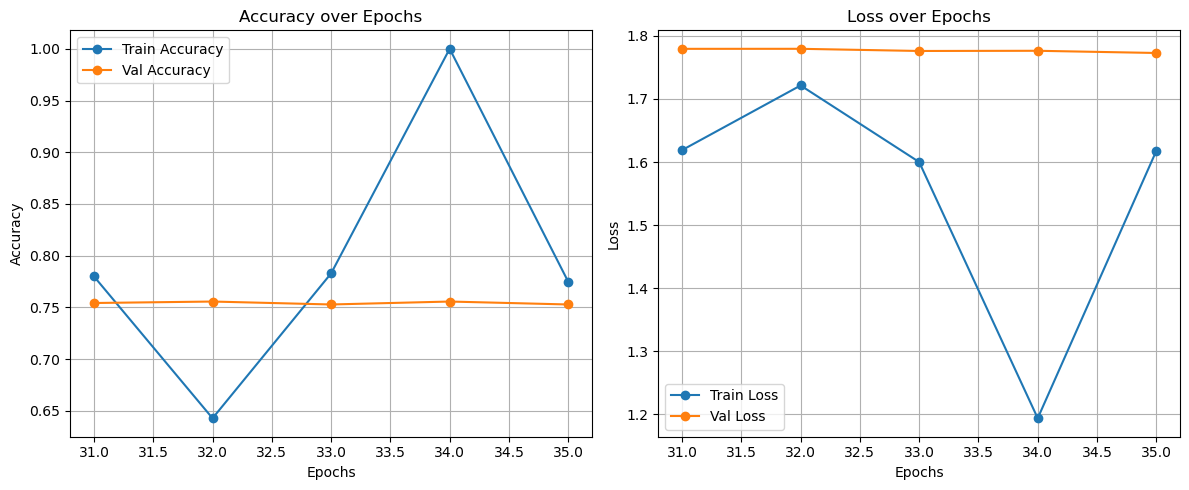


Epoch 35: val_loss improved from 1.77616 to 1.77297, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 194ms/step - accuracy: 0.5721 - auc: 0.8276 - loss: 2.1130 - precision_2: 0.6604 - recall_2: 0.4840 - val_accuracy: 0.7528 - val_auc: 0.9265 - val_loss: 1.7730 - val_precision_2: 0.8071 - val_recall_2: 0.7074 - learning_rate: 1.0000e-06
Epoch 36/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6429 - auc: 0.9037 - loss: 1.8921 - precision_2: 0.8182 - recall_2: 0.6429Epoch 36: Train Accuracy: 0.6429, Val Accuracy: 0.7514, Train Loss: 1.8921, Val Loss: 1.7741

Epoch 36: val_loss did not improve from 1.77297
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6429 - auc: 0.9037 - loss: 1.8921 - precision_2: 0.8182 - recall_2: 0.6429 - val_accuracy: 0.7514 - val_auc: 0.9264 - val_loss: 1.7741 - val_precision_2: 0.8055 - val_recall_2: 0.7060 - learning_rate: 1.0000e-06
Epoch 37/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.5758 - auc: 0.8288 - loss: 2.

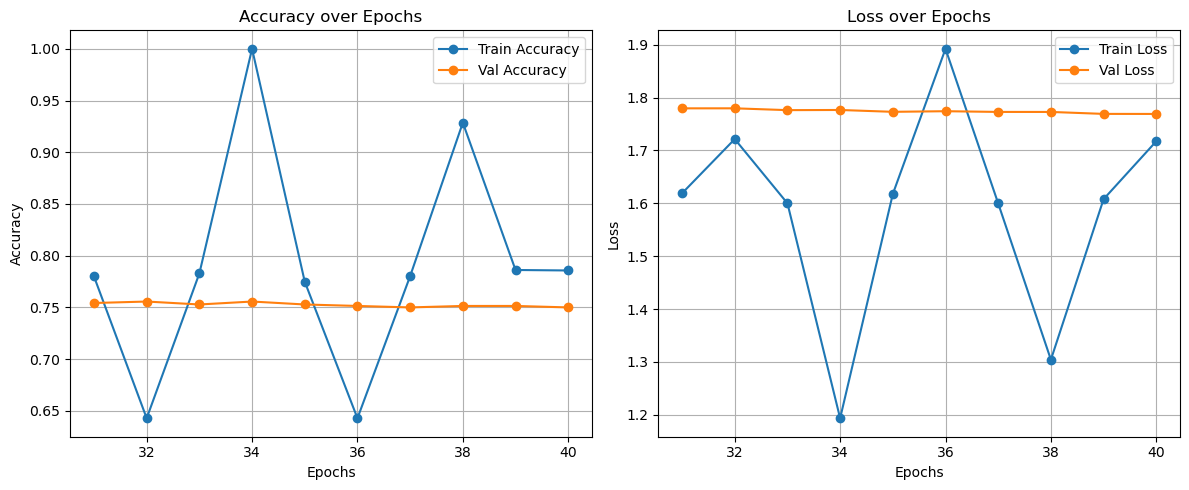


Epoch 40: val_loss improved from 1.76906 to 1.76896, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7857 - auc: 0.9222 - loss: 1.7173 - precision_2: 0.7857 - recall_2: 0.7857 - val_accuracy: 0.7500 - val_auc: 0.9269 - val_loss: 1.7690 - val_precision_2: 0.8108 - val_recall_2: 0.7060 - learning_rate: 1.0000e-06
Epoch 41/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.5855 - auc: 0.8332 - loss: 2.0848 - precision_2: 0.6781 - recall_2: 0.4959Epoch 41: Train Accuracy: 0.7812, Val Accuracy: 0.7500, Train Loss: 1.6125, Val Loss: 1.7673

Epoch 41: val_loss improved from 1.76896 to 1.76732, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 184ms/step - accuracy: 0.5876 - auc: 0.8344 - loss: 2.0799 - precision_2: 0.6800 - recall_2: 0.4981 - val_accuracy: 0.7500 - val_auc: 0.9271 - val_loss: 1.7673 - val_precision_2: 0.8049 - val_recall_2: 0.7031 - learning_rate: 1.0000e-06
Epoch 42/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - ac

2024-12-06 12:59:22.283111: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 42: Train Accuracy: 0.9286, Val Accuracy: 0.7514, Train Loss: 1.3735, Val Loss: 1.7678

Epoch 42: val_loss did not improve from 1.76732
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9286 - auc: 0.9898 - loss: 1.3735 - precision_2: 0.9091 - recall_2: 0.7143 - val_accuracy: 0.7514 - val_auc: 0.9271 - val_loss: 1.7678 - val_precision_2: 0.8059 - val_recall_2: 0.7017 - learning_rate: 1.0000e-06
Epoch 43/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.5865 - auc: 0.8349 - loss: 2.0754 - precision_2: 0.6840 - recall_2: 0.4993Epoch 43: Train Accuracy: 0.7863, Val Accuracy: 0.7585, Train Loss: 1.5940, Val Loss: 1.7649

Epoch 43: val_loss improved from 1.76732 to 1.76494, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 183ms/step - accuracy: 0.5886 - auc: 0.8361 - loss: 2.0704 - precision_2: 0.6859 - recall_2: 0.5017 - val_accuracy: 0.7585 - val_auc: 0.9272 - val_loss: 1.7649 - val_precision_2: 0.8072 - val_recall_2: 0.7017 - learning_rate: 1.0000e-06
Epo

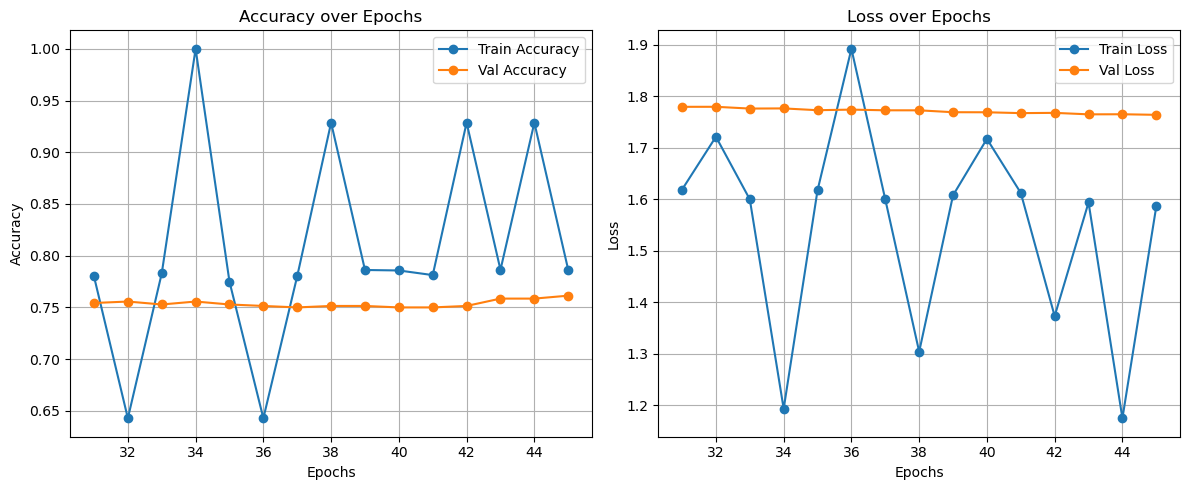


Epoch 45: val_loss improved from 1.76494 to 1.76400, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - accuracy: 0.5854 - auc: 0.8377 - loss: 2.0711 - precision_2: 0.6768 - recall_2: 0.4997 - val_accuracy: 0.7614 - val_auc: 0.9273 - val_loss: 1.7640 - val_precision_2: 0.8094 - val_recall_2: 0.7060 - learning_rate: 1.0000e-06
Epoch 46/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.1533 - precision_2: 1.0000 - recall_2: 1.0000Epoch 46: Train Accuracy: 1.0000, Val Accuracy: 0.7585, Train Loss: 1.1533, Val Loss: 1.7642

Epoch 46: val_loss did not improve from 1.76400
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.1533 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.7585 - val_auc: 0.9273 - val_loss: 1.7642 - val_precision_2: 0.8091 - val_recall_2: 0.7045 - learning_rate: 1.0000e-06
Epoch 47/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.5905 - auc: 0.8344 - loss: 2.

2024-12-06 13:00:40.824948: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 50: Train Accuracy: 0.7143, Val Accuracy: 0.7557, Train Loss: 1.8586, Val Loss: 1.7592


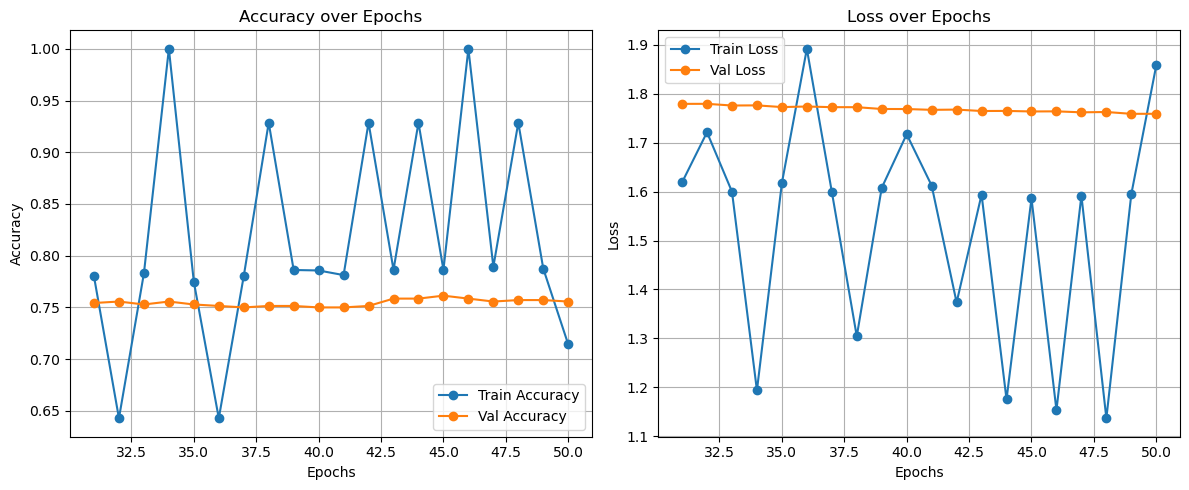


Epoch 50: val_loss did not improve from 1.75917
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7143 - auc: 0.9292 - loss: 1.8586 - precision_2: 0.6667 - recall_2: 0.5714 - val_accuracy: 0.7557 - val_auc: 0.9278 - val_loss: 1.7592 - val_precision_2: 0.8098 - val_recall_2: 0.7074 - learning_rate: 1.0000e-06
Epoch 51/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.5829 - auc: 0.8298 - loss: 2.0966 - precision_2: 0.6755 - recall_2: 0.4901Epoch 51: Train Accuracy: 0.7812, Val Accuracy: 0.7486, Train Loss: 1.6025, Val Loss: 1.7596

Epoch 51: val_loss did not improve from 1.75917
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 181ms/step - accuracy: 0.5849 - auc: 0.8311 - loss: 2.0915 - precision_2: 0.6775 - recall_2: 0.4925 - val_accuracy: 0.7486 - val_auc: 0.9274 - val_loss: 1.7596 - val_precision_2: 0.8081 - val_recall_2: 0.7060 - learning_rate: 1.0000e-06
Epoch 52/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8571 - auc: 0.9930 - loss: 1.2967 - precision_2: 0.9231 - recall_2

2024-12-06 13:01:00.102442: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 52: Train Accuracy: 0.8571, Val Accuracy: 0.7500, Train Loss: 1.2967, Val Loss: 1.7594

Epoch 52: val_loss did not improve from 1.75917

Epoch 52: ReduceLROnPlateau reducing learning rate to 1.9999999949504855e-07.
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8571 - auc: 0.9930 - loss: 1.2967 - precision_2: 0.9231 - recall_2: 0.8571 - val_accuracy: 0.7500 - val_auc: 0.9277 - val_loss: 1.7594 - val_precision_2: 0.8084 - val_recall_2: 0.7074 - learning_rate: 1.0000e-06
Epoch 53/100
 2/95 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.2188 - auc: 0.5838 - loss: 2.8587 - precision_2: 0.1849 - recall_2: 0.0898

2024-12-06 13:01:01.995992: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536448 bytes after encountering the first element of size 38536448 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5881 - auc: 0.8356 - loss: 2.0732 - precision_2: 0.6797 - recall_2: 0.4998Epoch 53: Train Accuracy: 0.7890, Val Accuracy: 0.7528, Train Loss: 1.5886, Val Loss: 1.7595

Epoch 53: val_loss did not improve from 1.75917
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 179ms/step - accuracy: 0.5901 - auc: 0.8368 - loss: 2.0682 - precision_2: 0.6817 - recall_2: 0.5021 - val_accuracy: 0.7528 - val_auc: 0.9274 - val_loss: 1.7595 - val_precision_2: 0.8046 - val_recall_2: 0.7017 - learning_rate: 2.0000e-07
Epoch 54/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9286 - auc: 0.9974 - loss: 1.2405 - precision_2: 0.9231 - recall_2: 0.8571

2024-12-06 13:01:19.049196: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 54: Train Accuracy: 0.9286, Val Accuracy: 0.7514, Train Loss: 1.2405, Val Loss: 1.7595

Epoch 54: val_loss did not improve from 1.75917
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9286 - auc: 0.9974 - loss: 1.2405 - precision_2: 0.9231 - recall_2: 0.8571 - val_accuracy: 0.7514 - val_auc: 0.9274 - val_loss: 1.7595 - val_precision_2: 0.8059 - val_recall_2: 0.7017 - learning_rate: 2.0000e-07
Epoch 55/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.5854 - auc: 0.8339 - loss: 2.0846 - precision_2: 0.6724 - recall_2: 0.4959Epoch 55: Train Accuracy: 0.7857, Val Accuracy: 0.7514, Train Loss: 1.5981, Val Loss: 1.7572


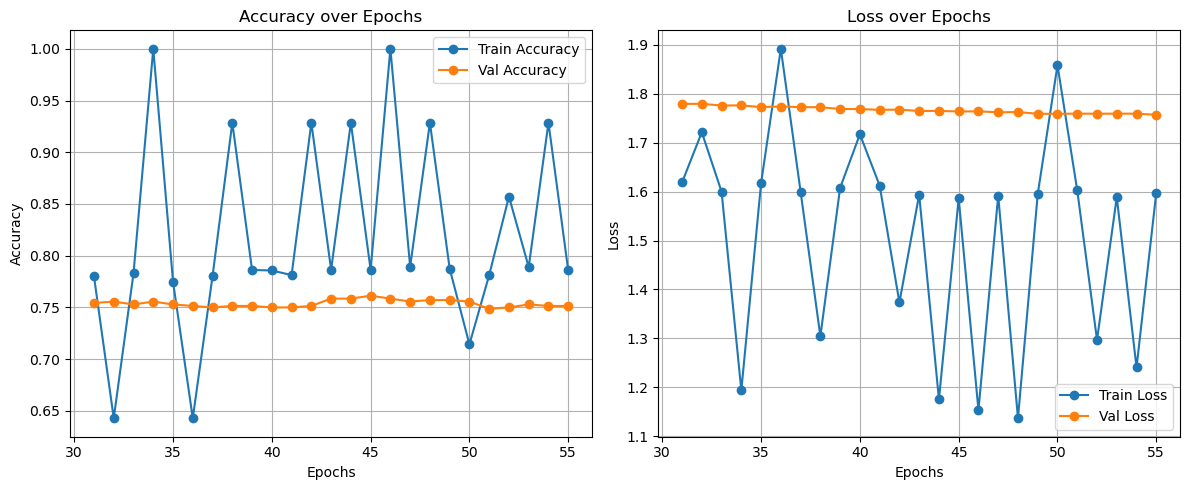


Epoch 55: val_loss improved from 1.75917 to 1.75718, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 191ms/step - accuracy: 0.5875 - auc: 0.8352 - loss: 2.0795 - precision_2: 0.6744 - recall_2: 0.4982 - val_accuracy: 0.7514 - val_auc: 0.9280 - val_loss: 1.7572 - val_precision_2: 0.8045 - val_recall_2: 0.7074 - learning_rate: 2.0000e-07
Epoch 56/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8571 - auc: 0.9949 - loss: 1.3013 - precision_2: 0.8571 - recall_2: 0.8571

2024-12-06 13:01:39.249260: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 56: Train Accuracy: 0.8571, Val Accuracy: 0.7543, Train Loss: 1.3013, Val Loss: 1.7571

Epoch 56: val_loss improved from 1.75718 to 1.75705, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8571 - auc: 0.9949 - loss: 1.3013 - precision_2: 0.8571 - recall_2: 0.8571 - val_accuracy: 0.7543 - val_auc: 0.9280 - val_loss: 1.7571 - val_precision_2: 0.8045 - val_recall_2: 0.7074 - learning_rate: 2.0000e-07
Epoch 57/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5946 - auc: 0.8371 - loss: 2.0721 - precision_2: 0.6867 - recall_2: 0.5050Epoch 57: Train Accuracy: 0.7900, Val Accuracy: 0.7543, Train Loss: 1.5837, Val Loss: 1.7567

Epoch 57: val_loss improved from 1.75705 to 1.75670, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - accuracy: 0.5967 - auc: 0.8383 - loss: 2.0670 - precision_2: 0.6886 - recall_2: 0.5073 - val_accuracy: 0.7543 - val_auc: 0.9280 - val_loss: 1.7567 - val_precision_2: 0.8036 - val_recall_2:

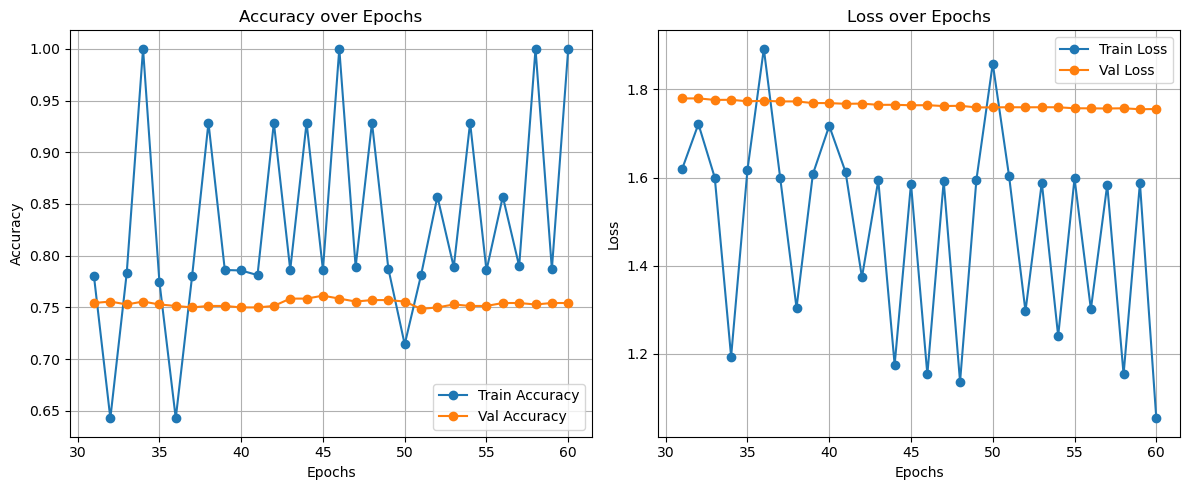


Epoch 60: val_loss did not improve from 1.75504
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.0539 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.7543 - val_auc: 0.9283 - val_loss: 1.7555 - val_precision_2: 0.8019 - val_recall_2: 0.7017 - learning_rate: 2.0000e-07
Epoch 61/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5727 - auc: 0.8323 - loss: 2.0895 - precision_2: 0.6644 - recall_2: 0.4864Epoch 61: Train Accuracy: 0.7801, Val Accuracy: 0.7543, Train Loss: 1.5967, Val Loss: 1.7541

Epoch 61: val_loss improved from 1.75504 to 1.75409, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 189ms/step - accuracy: 0.5748 - auc: 0.8336 - loss: 2.0843 - precision_2: 0.6664 - recall_2: 0.4888 - val_accuracy: 0.7543 - val_auc: 0.9282 - val_loss: 1.7541 - val_precision_2: 0.8065 - val_recall_2: 0.7045 - learning_rate: 2.0000e-07
Epoch 62/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7857 - auc: 0.9815 - loss: 1

2024-12-06 13:02:58.845516: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 64: Train Accuracy: 0.9286, Val Accuracy: 0.7557, Train Loss: 1.3408, Val Loss: 1.7543

Epoch 64: val_loss did not improve from 1.75402

Epoch 64: ReduceLROnPlateau reducing learning rate to 4.00000004674439e-08.
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9286 - auc: 0.9796 - loss: 1.3408 - precision_2: 0.9231 - recall_2: 0.8571 - val_accuracy: 0.7557 - val_auc: 0.9281 - val_loss: 1.7543 - val_precision_2: 0.8052 - val_recall_2: 0.7045 - learning_rate: 2.0000e-07
Epoch 65/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.5804 - auc: 0.8297 - loss: 2.0896 - precision_2: 0.6742 - recall_2: 0.4976Epoch 65: Train Accuracy: 0.7855, Val Accuracy: 0.7557, Train Loss: 1.5865, Val Loss: 1.7535


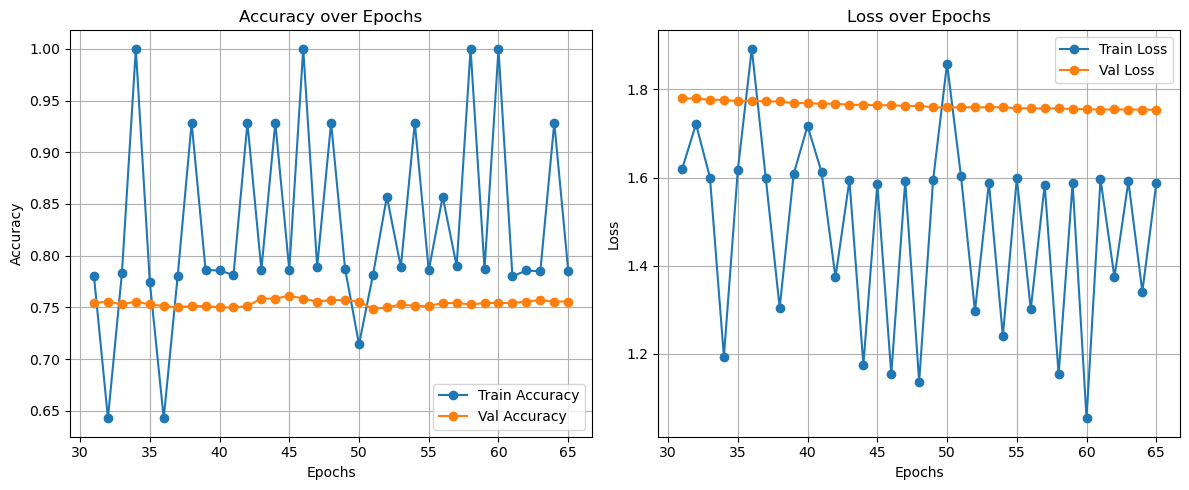


Epoch 65: val_loss improved from 1.75402 to 1.75346, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step - accuracy: 0.5826 - auc: 0.8310 - loss: 2.0843 - precision_2: 0.6762 - recall_2: 0.5000 - val_accuracy: 0.7557 - val_auc: 0.9282 - val_loss: 1.7535 - val_precision_2: 0.8042 - val_recall_2: 0.7003 - learning_rate: 4.0000e-08
Epoch 66/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8571 - auc: 0.9758 - loss: 1.4195 - precision_2: 0.9231 - recall_2: 0.8571

2024-12-06 13:03:18.835526: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 66: Train Accuracy: 0.8571, Val Accuracy: 0.7557, Train Loss: 1.4195, Val Loss: 1.7539

Epoch 66: val_loss did not improve from 1.75346
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8571 - auc: 0.9758 - loss: 1.4195 - precision_2: 0.9231 - recall_2: 0.8571 - val_accuracy: 0.7557 - val_auc: 0.9281 - val_loss: 1.7539 - val_precision_2: 0.8049 - val_recall_2: 0.7031 - learning_rate: 4.0000e-08
Epoch 67/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.5797 - auc: 0.8338 - loss: 2.0871 - precision_2: 0.6718 - recall_2: 0.4992Epoch 67: Train Accuracy: 0.7829, Val Accuracy: 0.7571, Train Loss: 1.5960, Val Loss: 1.7527

Epoch 67: val_loss improved from 1.75346 to 1.75274, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 194ms/step - accuracy: 0.5818 - auc: 0.8351 - loss: 2.0820 - precision_2: 0.6738 - recall_2: 0.5016 - val_accuracy: 0.7571 - val_auc: 0.9283 - val_loss: 1.7527 - val_precision_2: 0.8046 - val_recall_2: 0.7017 - learning_rate: 4.0000e-08
Epo

2024-12-06 13:03:39.229508: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 68: Train Accuracy: 0.9286, Val Accuracy: 0.7571, Train Loss: 1.4305, Val Loss: 1.7531

Epoch 68: val_loss did not improve from 1.75274
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9286 - auc: 0.9764 - loss: 1.4305 - precision_2: 0.9091 - recall_2: 0.7143 - val_accuracy: 0.7571 - val_auc: 0.9284 - val_loss: 1.7531 - val_precision_2: 0.8062 - val_recall_2: 0.7031 - learning_rate: 4.0000e-08
Epoch 69/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.5836 - auc: 0.8320 - loss: 2.0863 - precision_2: 0.6773 - recall_2: 0.5015Epoch 69: Train Accuracy: 0.7877, Val Accuracy: 0.7543, Train Loss: 1.5892, Val Loss: 1.7521

Epoch 69: val_loss improved from 1.75274 to 1.75210, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 182ms/step - accuracy: 0.5857 - auc: 0.8332 - loss: 2.0811 - precision_2: 0.6793 - recall_2: 0.5039 - val_accuracy: 0.7543 - val_auc: 0.9282 - val_loss: 1.7521 - val_precision_2: 0.8006 - val_recall_2: 0.7017 - learning_rate: 4.0000e-08
Epo

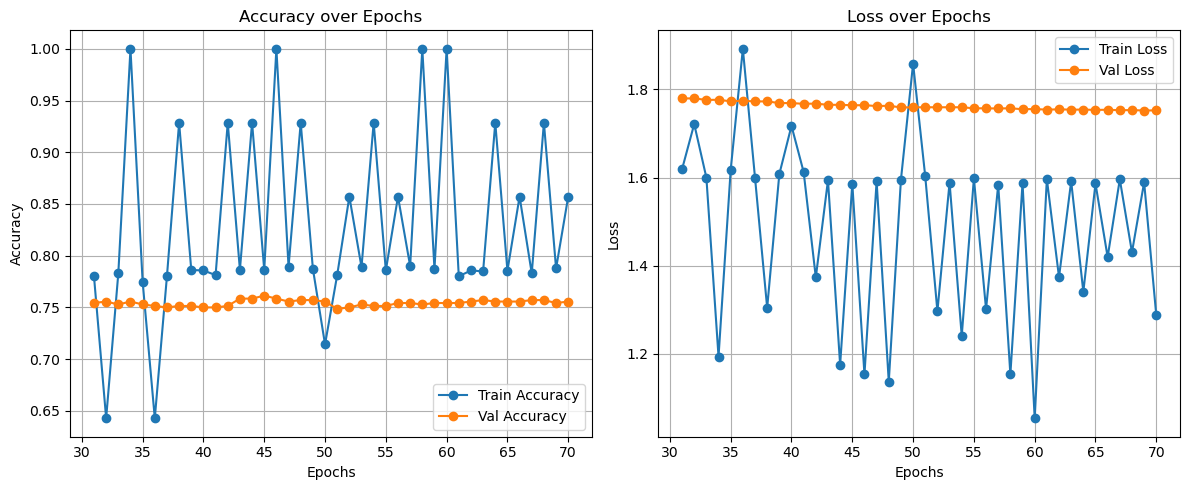


Epoch 70: val_loss did not improve from 1.75210
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8571 - auc: 0.9892 - loss: 1.2873 - precision_2: 0.9231 - recall_2: 0.8571 - val_accuracy: 0.7557 - val_auc: 0.9284 - val_loss: 1.7524 - val_precision_2: 0.8019 - val_recall_2: 0.7017 - learning_rate: 4.0000e-08
Epoch 71/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.5887 - auc: 0.8411 - loss: 2.0357 - precision_2: 0.6823 - recall_2: 0.4980

2024-12-06 13:04:16.527595: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 71: Train Accuracy: 0.7896, Val Accuracy: 0.7528, Train Loss: 1.5726, Val Loss: 1.7505

Epoch 71: val_loss improved from 1.75210 to 1.75050, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 184ms/step - accuracy: 0.5908 - auc: 0.8423 - loss: 2.0309 - precision_2: 0.6843 - recall_2: 0.5004 - val_accuracy: 0.7528 - val_auc: 0.9282 - val_loss: 1.7505 - val_precision_2: 0.8019 - val_recall_2: 0.7017 - learning_rate: 4.0000e-08
Epoch 72/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.1444 - precision_2: 1.0000 - recall_2: 1.0000Epoch 72: Train Accuracy: 1.0000, Val Accuracy: 0.7557, Train Loss: 1.1444, Val Loss: 1.7507

Epoch 72: val_loss did not improve from 1.75050
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.1444 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.7557 - val_auc: 0.9283 - val_loss: 1.7507 - val_precision_2: 0.8033 - val_recall_2: 0.7017 - learning_rate: 4.0000e-08
Epoc

2024-12-06 13:04:35.914392: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 73: Train Accuracy: 0.7882, Val Accuracy: 0.7557, Train Loss: 1.5904, Val Loss: 1.7518

Epoch 73: val_loss did not improve from 1.75050
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 177ms/step - accuracy: 0.5909 - auc: 0.8344 - loss: 2.0868 - precision_2: 0.6855 - recall_2: 0.5051 - val_accuracy: 0.7557 - val_auc: 0.9283 - val_loss: 1.7518 - val_precision_2: 0.8013 - val_recall_2: 0.6989 - learning_rate: 4.0000e-08
Epoch 74/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9286 - auc: 0.9783 - loss: 1.3648 - precision_2: 0.9231 - recall_2: 0.8571Epoch 74: Train Accuracy: 0.9286, Val Accuracy: 0.7557, Train Loss: 1.3648, Val Loss: 1.7517

Epoch 74: val_loss did not improve from 1.75050

Epoch 74: ReduceLROnPlateau reducing learning rate to 7.999999951380233e-09.
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9286 - auc: 0.9783 - loss: 1.3648 - precision_2: 0.9231 - recall_2: 0.8571 - val_accuracy: 0.7557 - val_auc: 0.9280 - val_loss: 1.7517 - val_precision_2: 0.8016 - val_recall_2:

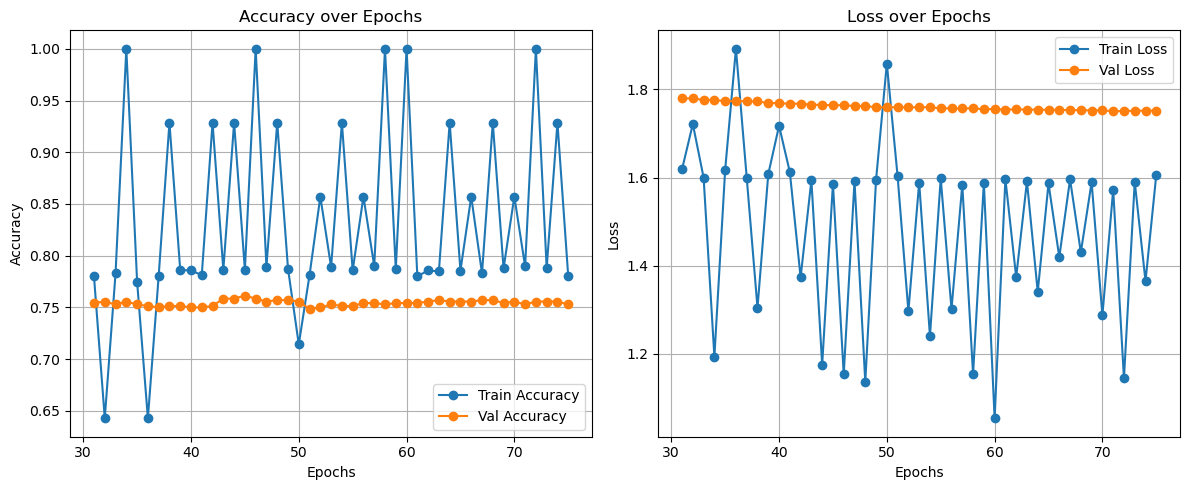


Epoch 75: val_loss did not improve from 1.75050
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 180ms/step - accuracy: 0.5873 - auc: 0.8304 - loss: 2.0927 - precision_2: 0.6672 - recall_2: 0.4970 - val_accuracy: 0.7528 - val_auc: 0.9283 - val_loss: 1.7518 - val_precision_2: 0.8016 - val_recall_2: 0.7003 - learning_rate: 8.0000e-09
Epoch 76/100
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.1769 - precision_2: 1.0000 - recall_2: 0.9286Epoch 76: Train Accuracy: 1.0000, Val Accuracy: 0.7514, Train Loss: 1.1769, Val Loss: 1.7515

Epoch 76: val_loss did not improve from 1.75050
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.1769 - precision_2: 1.0000 - recall_2: 0.9286 - val_accuracy: 0.7514 - val_auc: 0.9281 - val_loss: 1.7515 - val_precision_2: 0.8019 - val_recall_2: 0.7017 - learning_rate: 8.0000e-09
Epoch 77/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.5893 - auc: 0.8347 - loss: 2.0761 - precision_2: 0.6797 - recall_2

2024-12-06 13:05:34.873304: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 80: Train Accuracy: 0.6429, Val Accuracy: 0.7528, Train Loss: 1.6699, Val Loss: 1.7516


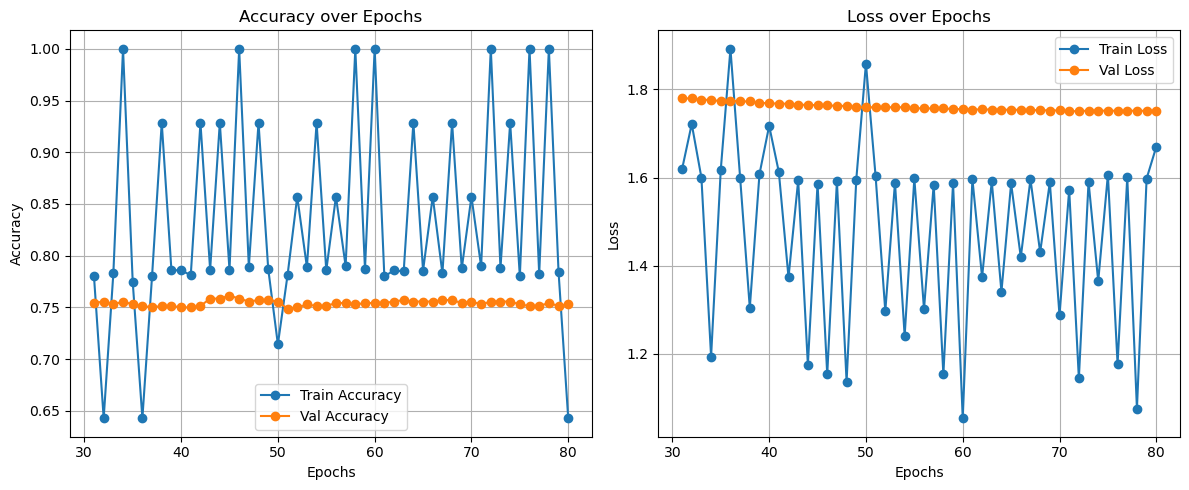


Epoch 80: val_loss did not improve from 1.75050

Epoch 80: ReduceLROnPlateau reducing learning rate to 3.1999998206799775e-10.
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6429 - auc: 0.9305 - loss: 1.6699 - precision_2: 0.6667 - recall_2: 0.4286 - val_accuracy: 0.7528 - val_auc: 0.9283 - val_loss: 1.7516 - val_precision_2: 0.8023 - val_recall_2: 0.7031 - learning_rate: 1.6000e-09
Epoch 81/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.5802 - auc: 0.8278 - loss: 2.1123 - precision_2: 0.6643 - recall_2: 0.4879Epoch 81: Train Accuracy: 0.7793, Val Accuracy: 0.7514, Train Loss: 1.6071, Val Loss: 1.7510

Epoch 81: val_loss did not improve from 1.75050
95/95 ━━━━━━━━━━━━━━━━━━━━ 27s 277ms/step - accuracy: 0.5822 - auc: 0.8291 - loss: 2.1071 - precision_2: 0.6664 - recall_2: 0.4903 - val_accuracy: 0.7514 - val_auc: 0.9283 - val_loss: 1.7510 - val_precision_2: 0.8023 - val_recall_2: 0.7031 - learning_rate: 3.2000e-10


In [16]:
from tensorflow.keras.optimizers import Adam

new_learning_rate = 1e-6  

model.compile(
optimizer=Adam(learning_rate=1e-6), 
loss='categorical_crossentropy',
metrics=[
        'accuracy',
        Precision(),
        Recall(),
        AUC(multi_label=False, name='auc')
        ]
)
print(f"Resuming training with a learning rate of {new_learning_rate}")

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
custom_metrics_callback = SimpleMetricsCallback(every_n_epochs=5, save_plots=False)

# Resume training
history = model.fit(
    train_dataset,
    steps_per_epoch=train_samples // BATCH_SIZE,
    validation_data=val_dataset,
    validation_steps=val_samples // BATCH_SIZE,
    epochs=100, 
    initial_epoch=30,
    callbacks=[custom_metrics_callback, model_checkpoint,reduce_lr,early_stopping]
)


Resuming training with a learning rate of 1e-07
Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.5873 - auc: 0.8292 - loss: 2.1041 - precision_3: 0.6671 - recall_3: 0.4914Epoch 1: Train Accuracy: 0.7844, Val Accuracy: 0.7543, Train Loss: 1.6075, Val Loss: 1.7521

Epoch 1: val_loss improved from inf to 1.75205, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 61s 223ms/step - accuracy: 0.5893 - auc: 0.8304 - loss: 2.0990 - precision_3: 0.6691 - recall_3: 0.4937 - val_accuracy: 0.7543 - val_auc: 0.9282 - val_loss: 1.7521 - val_precision_3: 0.8010 - val_recall_3: 0.6974
Epoch 2/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 30:00 19s/step - accuracy: 0.7857 - auc: 0.9764 - loss: 1.4060 - precision_3: 0.7692 - recall_3: 0.7143Epoch 2: Train Accuracy: 0.7857, Val Accuracy: 0.7528, Train Loss: 1.4060, Val Loss: 1.7521

Epoch 2: val_loss did not improve from 1.75205
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7857 - auc: 0.9764 - loss: 1.4060 - precision_3: 0.7692 - recal

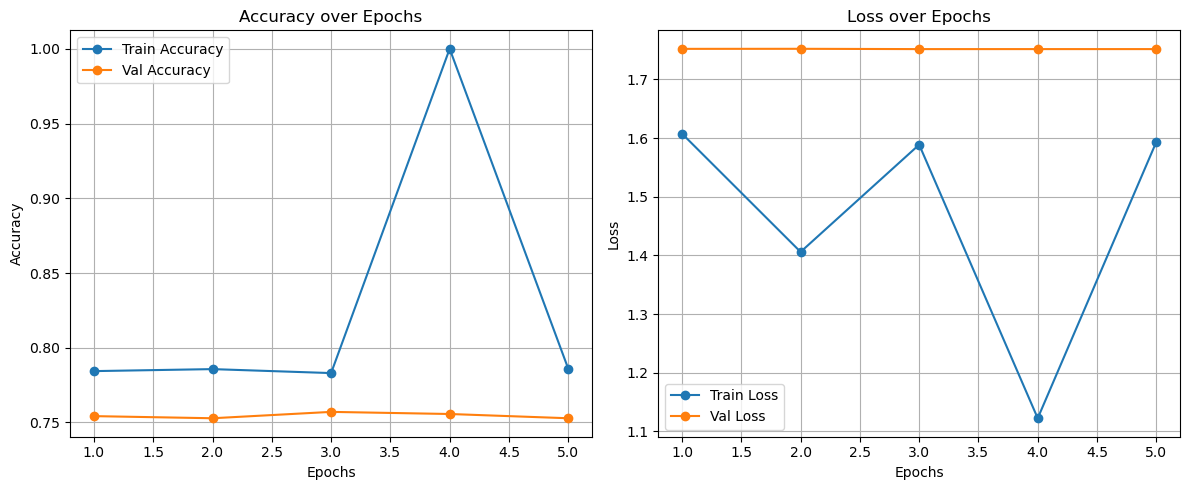


Epoch 5: val_loss did not improve from 1.75164
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 178ms/step - accuracy: 0.5942 - auc: 0.8375 - loss: 2.0652 - precision_3: 0.6861 - recall_3: 0.5046 - val_accuracy: 0.7528 - val_auc: 0.9283 - val_loss: 1.7517 - val_precision_3: 0.8006 - val_recall_3: 0.7017
Epoch 6/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.1186 - precision_3: 1.0000 - recall_3: 1.0000

2024-12-06 13:08:01.731477: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 393123393767902732
2024-12-06 13:08:01.802240: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 6: Train Accuracy: 1.0000, Val Accuracy: 0.7528, Train Loss: 1.1186, Val Loss: 1.7521

Epoch 6: val_loss did not improve from 1.75164
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.1186 - precision_3: 1.0000 - recall_3: 1.0000 - val_accuracy: 0.7528 - val_auc: 0.9283 - val_loss: 1.7521 - val_precision_3: 0.8023 - val_recall_3: 0.7031
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.5979 - auc: 0.8379 - loss: 2.0712 - precision_3: 0.6904 - recall_3: 0.5092Epoch 7: Train Accuracy: 0.7919, Val Accuracy: 0.7514, Train Loss: 1.5839, Val Loss: 1.7510

Epoch 7: val_loss improved from 1.75164 to 1.75097, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 181ms/step - accuracy: 0.5999 - auc: 0.8391 - loss: 2.0661 - precision_3: 0.6923 - recall_3: 0.5115 - val_accuracy: 0.7514 - val_auc: 0.9282 - val_loss: 1.7510 - val_precision_3: 0.7994 - val_recall_3: 0.7017
Epoch 8/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.

2024-12-06 13:08:20.953343: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 8: Train Accuracy: 0.7857, Val Accuracy: 0.7500, Train Loss: 1.4601, Val Loss: 1.7516

Epoch 8: val_loss did not improve from 1.75097
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7857 - auc: 0.9688 - loss: 1.4601 - precision_3: 0.9091 - recall_3: 0.7143 - val_accuracy: 0.7500 - val_auc: 0.9282 - val_loss: 1.7516 - val_precision_3: 0.8010 - val_recall_3: 0.7031
Epoch 9/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.5923 - auc: 0.8326 - loss: 2.0867 - precision_3: 0.6751 - recall_3: 0.4946Epoch 9: Train Accuracy: 0.7885, Val Accuracy: 0.7514, Train Loss: 1.5919, Val Loss: 1.7509

Epoch 9: val_loss improved from 1.75097 to 1.75089, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 180ms/step - accuracy: 0.5943 - auc: 0.8339 - loss: 2.0815 - precision_3: 0.6771 - recall_3: 0.4970 - val_accuracy: 0.7514 - val_auc: 0.9283 - val_loss: 1.7509 - val_precision_3: 0.8019 - val_recall_3: 0.7017
Epoch 10/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0

2024-12-06 13:08:39.973511: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 10: Train Accuracy: 0.8571, Val Accuracy: 0.7500, Train Loss: 1.3394, Val Loss: 1.7514


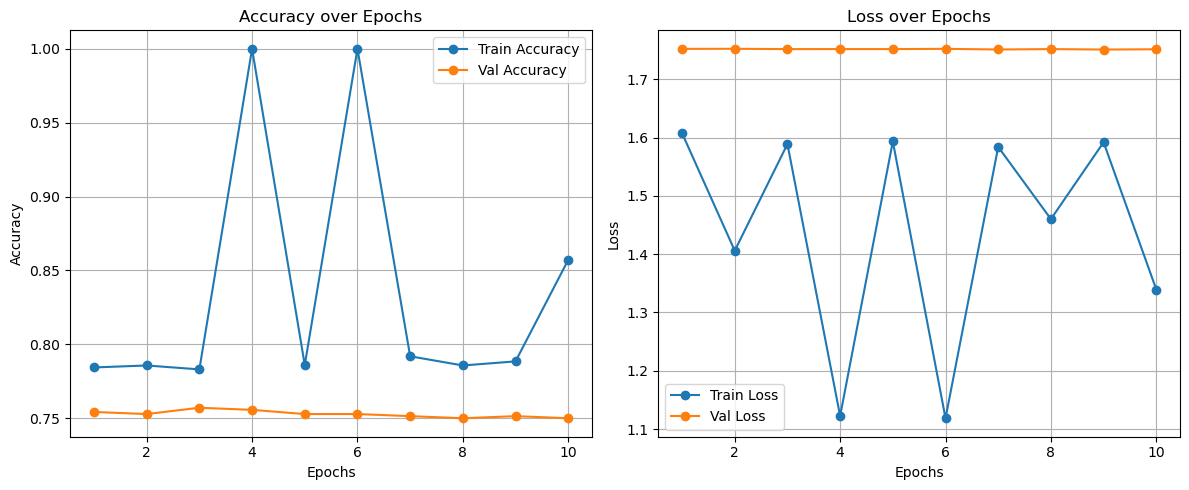


Epoch 10: val_loss did not improve from 1.75089
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8571 - auc: 0.9872 - loss: 1.3394 - precision_3: 0.8571 - recall_3: 0.8571 - val_accuracy: 0.7500 - val_auc: 0.9283 - val_loss: 1.7514 - val_precision_3: 0.8006 - val_recall_3: 0.7017
Epoch 11/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.5765 - auc: 0.8342 - loss: 2.0806 - precision_3: 0.6732 - recall_3: 0.4893

2024-12-06 13:08:57.576979: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 11: Train Accuracy: 0.7819, Val Accuracy: 0.7514, Train Loss: 1.5940, Val Loss: 1.7508

Epoch 11: val_loss improved from 1.75089 to 1.75078, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 179ms/step - accuracy: 0.5786 - auc: 0.8354 - loss: 2.0755 - precision_3: 0.6752 - recall_3: 0.4917 - val_accuracy: 0.7514 - val_auc: 0.9287 - val_loss: 1.7508 - val_precision_3: 0.8013 - val_recall_3: 0.6989
Epoch 12/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.0682 - precision_3: 1.0000 - recall_3: 1.0000

2024-12-06 13:08:58.980343: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 12: Train Accuracy: 1.0000, Val Accuracy: 0.7514, Train Loss: 1.0682, Val Loss: 1.7509

Epoch 12: val_loss did not improve from 1.75078
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.0682 - precision_3: 1.0000 - recall_3: 1.0000 - val_accuracy: 0.7514 - val_auc: 0.9287 - val_loss: 1.7509 - val_precision_3: 0.8019 - val_recall_3: 0.7017
Epoch 13/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5835 - auc: 0.8341 - loss: 2.0821 - precision_3: 0.6799 - recall_3: 0.4935Epoch 13: Train Accuracy: 0.7816, Val Accuracy: 0.7514, Train Loss: 1.5948, Val Loss: 1.7506

Epoch 13: val_loss improved from 1.75078 to 1.75061, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 184ms/step - accuracy: 0.5856 - auc: 0.8354 - loss: 2.0771 - precision_3: 0.6818 - recall_3: 0.4958 - val_accuracy: 0.7514 - val_auc: 0.9286 - val_loss: 1.7506 - val_precision_3: 0.8016 - val_recall_3: 0.7060
Epoch 14/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accura

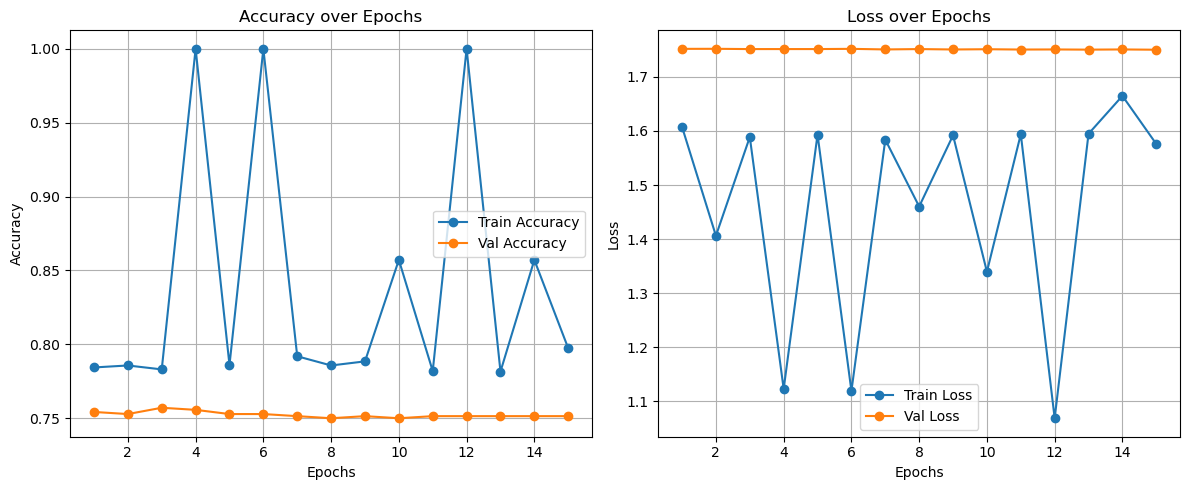


Epoch 15: val_loss improved from 1.75061 to 1.75043, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 181ms/step - accuracy: 0.6062 - auc: 0.8402 - loss: 2.0556 - precision_3: 0.6842 - recall_3: 0.5156 - val_accuracy: 0.7514 - val_auc: 0.9289 - val_loss: 1.7504 - val_precision_3: 0.8000 - val_recall_3: 0.7045
Epoch 16/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2143 - auc: 0.5804 - loss: 3.2320 - precision_3: 0.2222 - recall_3: 0.1429Epoch 16: Train Accuracy: 0.2143, Val Accuracy: 0.7528, Train Loss: 3.2320, Val Loss: 1.7498

Epoch 16: val_loss improved from 1.75043 to 1.74980, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2143 - auc: 0.5804 - loss: 3.2320 - precision_3: 0.2222 - recall_3: 0.1429 - val_accuracy: 0.7528 - val_auc: 0.9286 - val_loss: 1.7498 - val_precision_3: 0.8000 - val_recall_3: 0.7045
Epoch 17/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.5838 - auc: 0.8298 - loss: 2.0971 - precision_3:

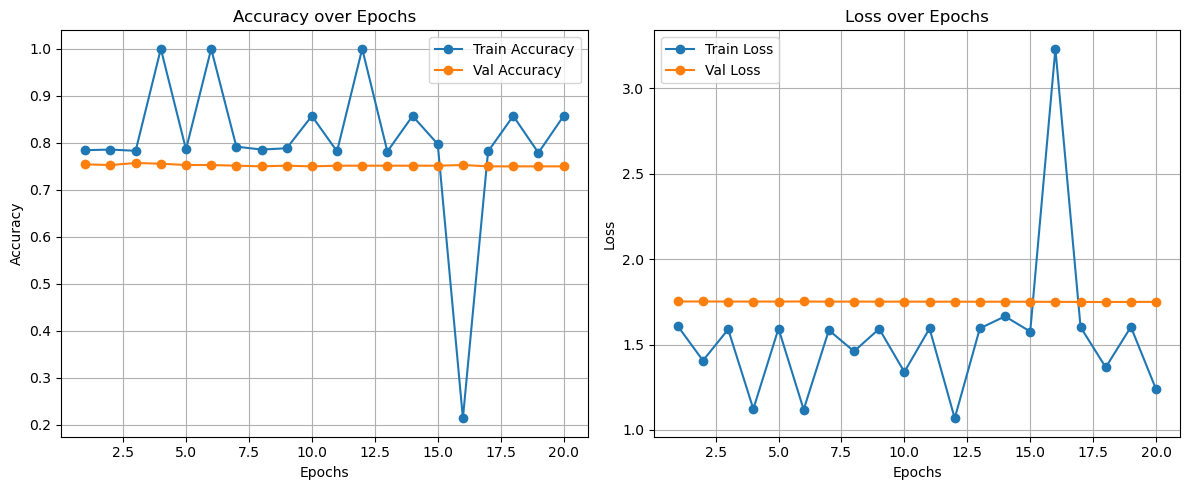


Epoch 20: val_loss did not improve from 1.74894
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8571 - auc: 0.9923 - loss: 1.2375 - precision_3: 0.9231 - recall_3: 0.8571 - val_accuracy: 0.7500 - val_auc: 0.9283 - val_loss: 1.7500 - val_precision_3: 0.8013 - val_recall_3: 0.7045
Epoch 21/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.5730 - auc: 0.8300 - loss: 2.0927 - precision_3: 0.6635 - recall_3: 0.4860Epoch 21: Train Accuracy: 0.7781, Val Accuracy: 0.7500, Train Loss: 1.5998, Val Loss: 1.7503

Epoch 21: val_loss did not improve from 1.74894
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 180ms/step - accuracy: 0.5752 - auc: 0.8313 - loss: 2.0875 - precision_3: 0.6656 - recall_3: 0.4884 - val_accuracy: 0.7500 - val_auc: 0.9284 - val_loss: 1.7503 - val_precision_3: 0.8019 - val_recall_3: 0.7017
Epoch 22/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9286 - auc: 0.9898 - loss: 1.2313 - precision_3: 0.9231 - recall_3: 0.8571

2024-12-06 13:10:36.563841: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 22: Train Accuracy: 0.9286, Val Accuracy: 0.7500, Train Loss: 1.2313, Val Loss: 1.7506

Epoch 22: val_loss did not improve from 1.74894
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9286 - auc: 0.9898 - loss: 1.2313 - precision_3: 0.9231 - recall_3: 0.8571 - val_accuracy: 0.7500 - val_auc: 0.9284 - val_loss: 1.7506 - val_precision_3: 0.7994 - val_recall_3: 0.7017
Epoch 23/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5850 - auc: 0.8363 - loss: 2.0667 - precision_3: 0.6752 - recall_3: 0.4978Epoch 23: Train Accuracy: 0.7878, Val Accuracy: 0.7486, Train Loss: 1.5822, Val Loss: 1.7494

Epoch 23: val_loss did not improve from 1.74894
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 177ms/step - accuracy: 0.5871 - auc: 0.8376 - loss: 2.0616 - precision_3: 0.6772 - recall_3: 0.5002 - val_accuracy: 0.7486 - val_auc: 0.9286 - val_loss: 1.7494 - val_precision_3: 0.7997 - val_recall_3: 0.7031
Epoch 24/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9286 - auc: 0.9987 - loss: 1.133

2024-12-06 13:10:55.458891: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 24: Train Accuracy: 0.9286, Val Accuracy: 0.7500, Train Loss: 1.1338, Val Loss: 1.7498

Epoch 24: val_loss did not improve from 1.74894
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9286 - auc: 0.9987 - loss: 1.1338 - precision_3: 0.9286 - recall_3: 0.9286 - val_accuracy: 0.7500 - val_auc: 0.9284 - val_loss: 1.7498 - val_precision_3: 0.8000 - val_recall_3: 0.7045
Epoch 25/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.5932 - auc: 0.8356 - loss: 2.0714 - precision_3: 0.6963 - recall_3: 0.5108Epoch 25: Train Accuracy: 0.7934, Val Accuracy: 0.7514, Train Loss: 1.5743, Val Loss: 1.7484


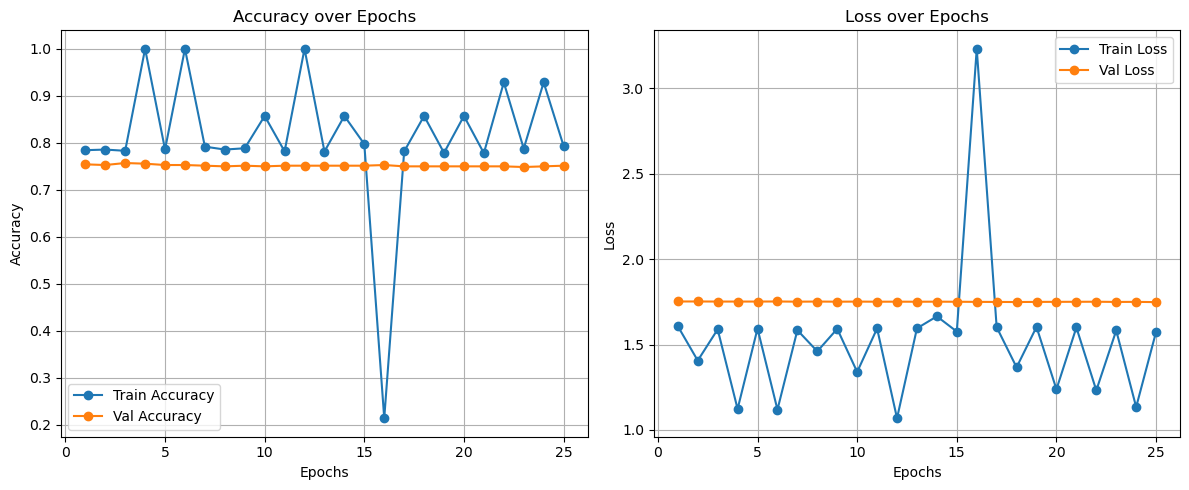


Epoch 25: val_loss improved from 1.74894 to 1.74838, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 189ms/step - accuracy: 0.5952 - auc: 0.8368 - loss: 2.0662 - precision_3: 0.6983 - recall_3: 0.5131 - val_accuracy: 0.7514 - val_auc: 0.9284 - val_loss: 1.7484 - val_precision_3: 0.7997 - val_recall_3: 0.7031
Epoch 26/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9286 - auc: 0.9936 - loss: 1.1994 - precision_3: 0.9286 - recall_3: 0.9286Epoch 26: Train Accuracy: 0.9286, Val Accuracy: 0.7500, Train Loss: 1.1994, Val Loss: 1.7490

Epoch 26: val_loss did not improve from 1.74838
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9286 - auc: 0.9936 - loss: 1.1994 - precision_3: 0.9286 - recall_3: 0.9286 - val_accuracy: 0.7500 - val_auc: 0.9284 - val_loss: 1.7490 - val_precision_3: 0.8006 - val_recall_3: 0.7017
Epoch 27/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.5857 - auc: 0.8341 - loss: 2.0887 - precision_3: 0.6741 - recall_3: 0.5004

2024-12-06 13:11:35.968597: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 27: Train Accuracy: 0.7809, Val Accuracy: 0.7500, Train Loss: 1.5957, Val Loss: 1.7495

Epoch 27: val_loss did not improve from 1.74838
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 176ms/step - accuracy: 0.5877 - auc: 0.8353 - loss: 2.0836 - precision_3: 0.6761 - recall_3: 0.5028 - val_accuracy: 0.7500 - val_auc: 0.9283 - val_loss: 1.7495 - val_precision_3: 0.8006 - val_recall_3: 0.7017
Epoch 28/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9286 - auc: 0.9802 - loss: 1.3398 - precision_3: 0.9286 - recall_3: 0.9286Epoch 28: Train Accuracy: 0.9286, Val Accuracy: 0.7500, Train Loss: 1.3398, Val Loss: 1.7494

Epoch 28: val_loss did not improve from 1.74838
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9286 - auc: 0.9802 - loss: 1.3398 - precision_3: 0.9286 - recall_3: 0.9286 - val_accuracy: 0.7500 - val_auc: 0.9283 - val_loss: 1.7494 - val_precision_3: 0.7984 - val_recall_3: 0.7031
Epoch 29/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.5927 - auc: 0.8379 - loss: 2.059

2024-12-06 13:11:56.137896: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 393123393767902732


Epoch 30: Train Accuracy: 0.8571, Val Accuracy: 0.7528, Train Loss: 1.2711, Val Loss: 1.7489


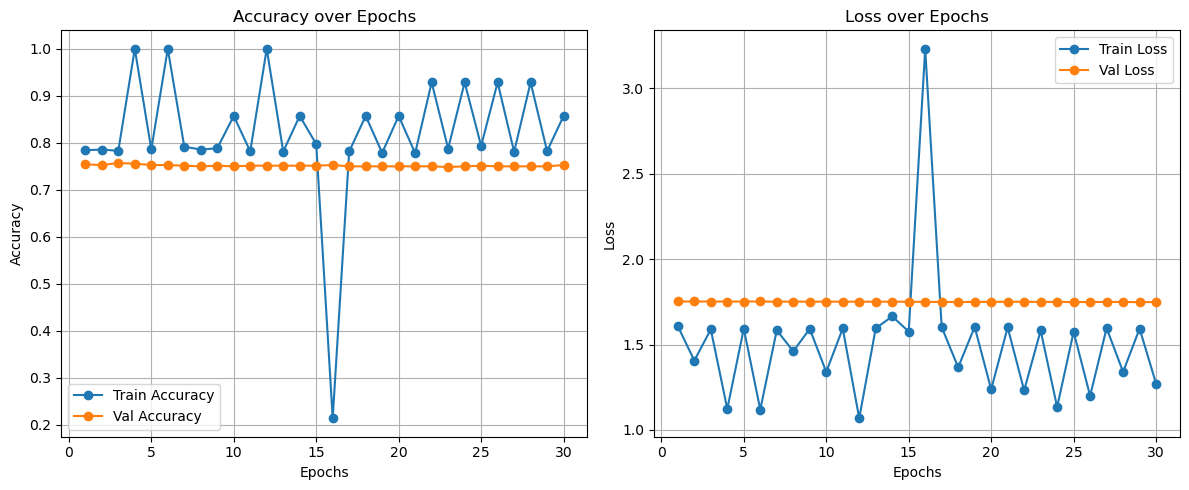


Epoch 30: val_loss did not improve from 1.74807
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8571 - auc: 0.9923 - loss: 1.2711 - precision_3: 0.9231 - recall_3: 0.8571 - val_accuracy: 0.7528 - val_auc: 0.9284 - val_loss: 1.7489 - val_precision_3: 0.8019 - val_recall_3: 0.7017
Epoch 31/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5898 - auc: 0.8339 - loss: 2.0939 - precision_3: 0.6828 - recall_3: 0.5147Epoch 31: Train Accuracy: 0.7916, Val Accuracy: 0.7500, Train Loss: 1.5895, Val Loss: 1.7477

Epoch 31: val_loss improved from 1.74807 to 1.74772, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 184ms/step - accuracy: 0.5919 - auc: 0.8352 - loss: 2.0886 - precision_3: 0.6847 - recall_3: 0.5170 - val_accuracy: 0.7500 - val_auc: 0.9286 - val_loss: 1.7477 - val_precision_3: 0.8000 - val_recall_3: 0.7045
Epoch 32/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9286 - auc: 0.9802 - loss: 1.3818 - precision_3: 0.9167 - recall_3: 0.7857

2024-12-06 13:12:15.732850: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 393123393767902732
2024-12-06 13:12:15.832236: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 32: Train Accuracy: 0.9286, Val Accuracy: 0.7500, Train Loss: 1.3818, Val Loss: 1.7480

Epoch 32: val_loss did not improve from 1.74772
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9286 - auc: 0.9802 - loss: 1.3818 - precision_3: 0.9167 - recall_3: 0.7857 - val_accuracy: 0.7500 - val_auc: 0.9290 - val_loss: 1.7480 - val_precision_3: 0.8000 - val_recall_3: 0.7045
Epoch 33/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.5733 - auc: 0.8282 - loss: 2.0992 - precision_3: 0.6634 - recall_3: 0.4865Epoch 33: Train Accuracy: 0.7765, Val Accuracy: 0.7514, Train Loss: 1.6050, Val Loss: 1.7484

Epoch 33: val_loss did not improve from 1.74772
95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 205ms/step - accuracy: 0.5754 - auc: 0.8295 - loss: 2.0941 - precision_3: 0.6655 - recall_3: 0.4889 - val_accuracy: 0.7514 - val_auc: 0.9288 - val_loss: 1.7484 - val_precision_3: 0.7968 - val_recall_3: 0.7017
Epoch 34/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9286 - auc: 0.9987 - loss: 1.148

2024-12-06 13:12:37.312383: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 34: Train Accuracy: 0.9286, Val Accuracy: 0.7514, Train Loss: 1.1480, Val Loss: 1.7484

Epoch 34: val_loss did not improve from 1.74772
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9286 - auc: 0.9987 - loss: 1.1480 - precision_3: 1.0000 - recall_3: 0.9286 - val_accuracy: 0.7514 - val_auc: 0.9288 - val_loss: 1.7484 - val_precision_3: 0.7968 - val_recall_3: 0.7017
Epoch 35/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5854 - auc: 0.8294 - loss: 2.0969 - precision_3: 0.6744 - recall_3: 0.4947Epoch 35: Train Accuracy: 0.7905, Val Accuracy: 0.7500, Train Loss: 1.5946, Val Loss: 1.7482


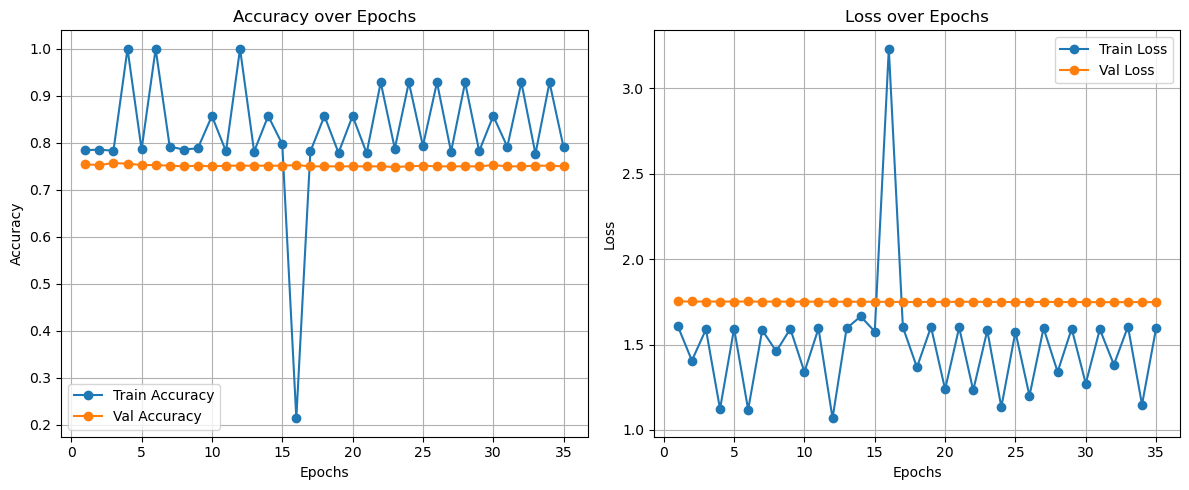


Epoch 35: val_loss did not improve from 1.74772
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 179ms/step - accuracy: 0.5875 - auc: 0.8307 - loss: 2.0917 - precision_3: 0.6765 - recall_3: 0.4971 - val_accuracy: 0.7500 - val_auc: 0.9288 - val_loss: 1.7482 - val_precision_3: 0.7977 - val_recall_3: 0.7003
Epoch 36/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.1077 - precision_3: 1.0000 - recall_3: 1.0000Epoch 36: Train Accuracy: 1.0000, Val Accuracy: 0.7514, Train Loss: 1.1077, Val Loss: 1.7483

Epoch 36: val_loss did not improve from 1.74772
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.1077 - precision_3: 1.0000 - recall_3: 1.0000 - val_accuracy: 0.7514 - val_auc: 0.9288 - val_loss: 1.7483 - val_precision_3: 0.7994 - val_recall_3: 0.7017
Epoch 37/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.5699 - auc: 0.8293 - loss: 2.1020 - precision_3: 0.6557 - recall_3: 0.4899Epoch 37: Train Accuracy: 0.7753, Val Accuracy: 0.7

2024-12-06 13:13:15.020239: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 38: Train Accuracy: 0.9286, Val Accuracy: 0.7500, Train Loss: 1.0886, Val Loss: 1.7490

Epoch 38: val_loss did not improve from 1.74772
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9286 - auc: 0.9987 - loss: 1.0886 - precision_3: 1.0000 - recall_3: 0.9286 - val_accuracy: 0.7500 - val_auc: 0.9288 - val_loss: 1.7490 - val_precision_3: 0.7981 - val_recall_3: 0.7017
Epoch 39/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.5997 - auc: 0.8405 - loss: 2.0543 - precision_3: 0.6852 - recall_3: 0.5063Epoch 39: Train Accuracy: 0.7942, Val Accuracy: 0.7514, Train Loss: 1.5707, Val Loss: 1.7491

Epoch 39: val_loss did not improve from 1.74772
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 176ms/step - accuracy: 0.6017 - auc: 0.8417 - loss: 2.0493 - precision_3: 0.6871 - recall_3: 0.5086 - val_accuracy: 0.7514 - val_auc: 0.9288 - val_loss: 1.7491 - val_precision_3: 0.7984 - val_recall_3: 0.7031
Epoch 40/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7857 - auc: 0.9700 - loss: 1.417

2024-12-06 13:13:33.847651: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 40: Train Accuracy: 0.7857, Val Accuracy: 0.7514, Train Loss: 1.4172, Val Loss: 1.7492


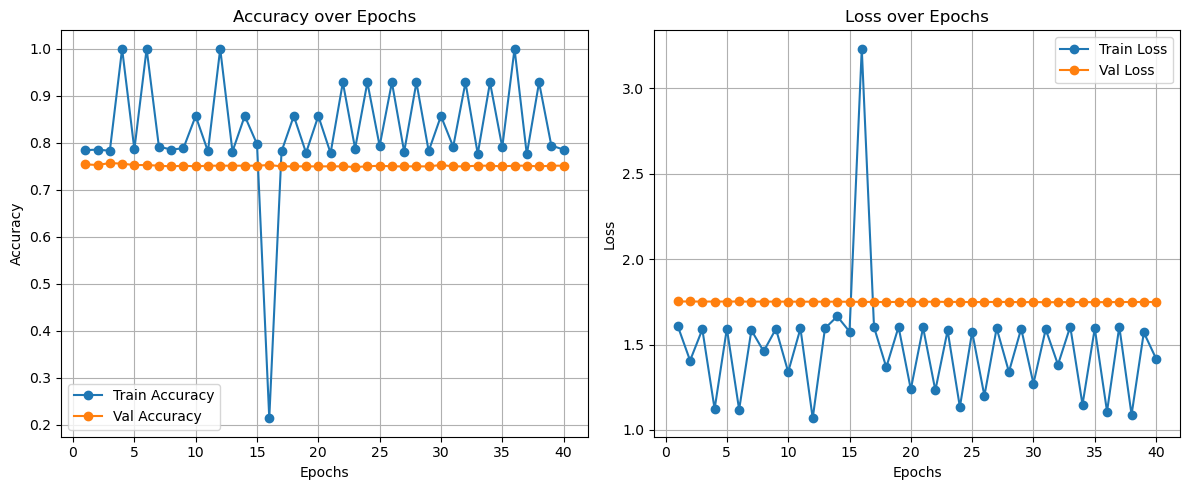


Epoch 40: val_loss did not improve from 1.74772
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7857 - auc: 0.9700 - loss: 1.4172 - precision_3: 0.9167 - recall_3: 0.7857 - val_accuracy: 0.7514 - val_auc: 0.9284 - val_loss: 1.7492 - val_precision_3: 0.7977 - val_recall_3: 0.7003
Epoch 41/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5883 - auc: 0.8316 - loss: 2.0920 - precision_3: 0.6730 - recall_3: 0.4959Epoch 41: Train Accuracy: 0.7877, Val Accuracy: 0.7528, Train Loss: 1.5892, Val Loss: 1.7501

Epoch 41: val_loss did not improve from 1.74772
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 177ms/step - accuracy: 0.5903 - auc: 0.8329 - loss: 2.0868 - precision_3: 0.6750 - recall_3: 0.4982 - val_accuracy: 0.7528 - val_auc: 0.9289 - val_loss: 1.7501 - val_precision_3: 0.7994 - val_recall_3: 0.7017
Epoch 42/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9286 - auc: 0.9936 - loss: 1.2374 - precision_3: 0.9231 - recall_3: 0.8571Epoch 42: Train Accuracy: 0.9286, Val Accuracy: 0.7

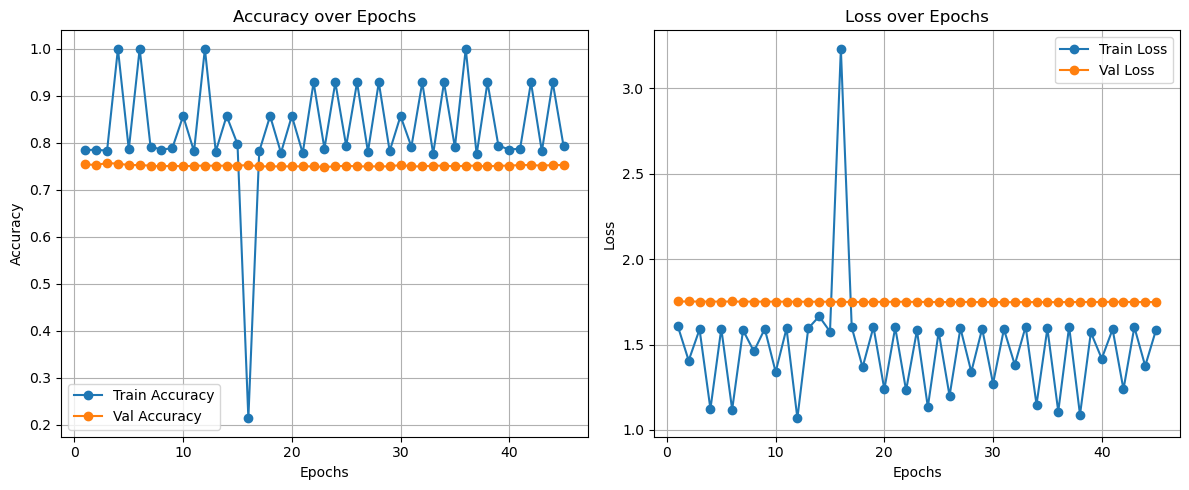


Epoch 45: val_loss did not improve from 1.74772
95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 213ms/step - accuracy: 0.5939 - auc: 0.8360 - loss: 2.0759 - precision_3: 0.6904 - recall_3: 0.5044 - val_accuracy: 0.7528 - val_auc: 0.9286 - val_loss: 1.7486 - val_precision_3: 0.7974 - val_recall_3: 0.6989
Epoch 46/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.0521 - precision_3: 1.0000 - recall_3: 1.0000

2024-12-06 13:14:34.281727: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 46: Train Accuracy: 1.0000, Val Accuracy: 0.7528, Train Loss: 1.0521, Val Loss: 1.7486

Epoch 46: val_loss did not improve from 1.74772
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.0521 - precision_3: 1.0000 - recall_3: 1.0000 - val_accuracy: 0.7528 - val_auc: 0.9286 - val_loss: 1.7486 - val_precision_3: 0.7981 - val_recall_3: 0.7017
Epoch 47/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.5845 - auc: 0.8337 - loss: 2.0810 - precision_3: 0.6725 - recall_3: 0.5001Epoch 47: Train Accuracy: 0.7844, Val Accuracy: 0.7514, Train Loss: 1.5887, Val Loss: 1.7479

Epoch 47: val_loss did not improve from 1.74772
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 176ms/step - accuracy: 0.5865 - auc: 0.8349 - loss: 2.0759 - precision_3: 0.6745 - recall_3: 0.5024 - val_accuracy: 0.7514 - val_auc: 0.9284 - val_loss: 1.7479 - val_precision_3: 0.8010 - val_recall_3: 0.7031
Epoch 48/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8571 - auc: 0.9739 - loss: 1.418

2024-12-06 13:14:52.796766: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 393123393767902732


Epoch 48: Train Accuracy: 0.8571, Val Accuracy: 0.7500, Train Loss: 1.4188, Val Loss: 1.7490

Epoch 48: val_loss did not improve from 1.74772
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8571 - auc: 0.9739 - loss: 1.4188 - precision_3: 0.8462 - recall_3: 0.7857 - val_accuracy: 0.7500 - val_auc: 0.9284 - val_loss: 1.7490 - val_precision_3: 0.7994 - val_recall_3: 0.7017
Epoch 49/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5917 - auc: 0.8379 - loss: 2.0541 - precision_3: 0.6989 - recall_3: 0.5140Epoch 49: Train Accuracy: 0.7959, Val Accuracy: 0.7500, Train Loss: 1.5663, Val Loss: 1.7469

Epoch 49: val_loss improved from 1.74772 to 1.74694, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 183ms/step - accuracy: 0.5938 - auc: 0.8392 - loss: 2.0490 - precision_3: 0.7008 - recall_3: 0.5164 - val_accuracy: 0.7500 - val_auc: 0.9287 - val_loss: 1.7469 - val_precision_3: 0.8006 - val_recall_3: 0.7017
Epoch 50/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accur

2024-12-06 13:15:12.356094: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 50: Train Accuracy: 0.5714, Val Accuracy: 0.7486, Train Loss: 2.0890, Val Loss: 1.7474


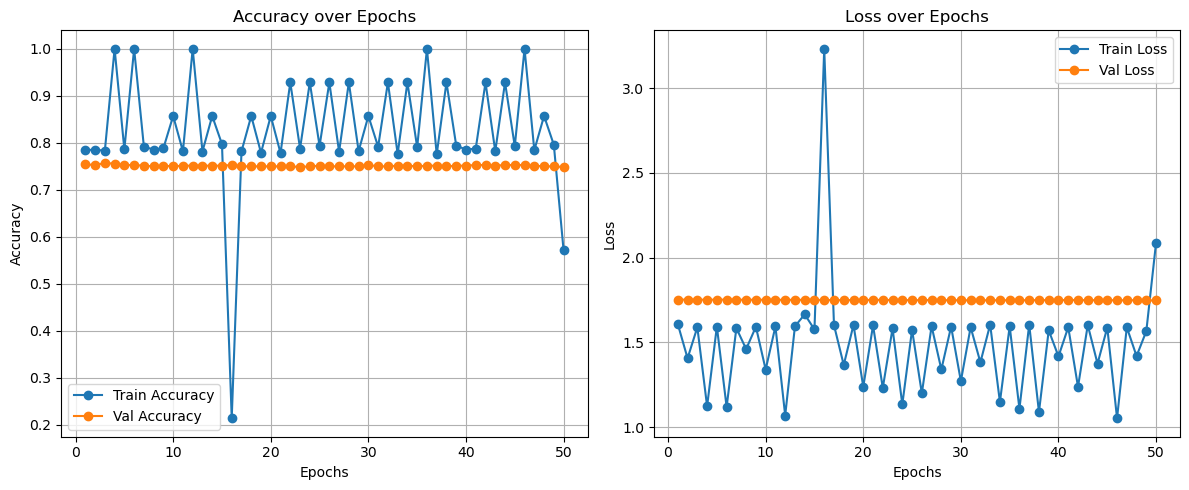


Epoch 50: val_loss did not improve from 1.74694
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5714 - auc: 0.8527 - loss: 2.0890 - precision_3: 0.5833 - recall_3: 0.5000 - val_accuracy: 0.7486 - val_auc: 0.9287 - val_loss: 1.7474 - val_precision_3: 0.7984 - val_recall_3: 0.7031


In [17]:
from tensorflow.keras.optimizers import Adam

new_learning_rate = 1e-7  

model.compile(
optimizer=Adam(learning_rate=1e-7), 
loss='categorical_crossentropy',
metrics=[
        'accuracy',
        Precision(),
        Recall(),
        AUC(multi_label=False, name='auc')
        ]
)
print(f"Resuming training with a learning rate of {new_learning_rate}")

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
custom_metrics_callback = SimpleMetricsCallback(every_n_epochs=5, save_plots=False)

# Resume training
history = model.fit(
    train_dataset,
    steps_per_epoch=train_samples // BATCH_SIZE,
    validation_data=val_dataset,
    validation_steps=val_samples // BATCH_SIZE,
    epochs=50, 
    callbacks=[custom_metrics_callback, model_checkpoint]
)


## Testing on test data

In [18]:
import tensorflow as tf

# Function to count the number of samples in the TFRecord
def count_samples(tfrecord_filename):
    count = 0
    for record in tf.data.TFRecordDataset(tfrecord_filename):
        count += 1
    return count

# Calculate the number of samples in the training TFRecord
test_samples = count_samples('/media/mydisk/ICDCIT/TFRecords_preprocessed_APTOS/test.tfrecord')

print(f'test_samples: {test_samples}')

test_samples: 366


In [19]:
results = model.evaluate(test_dataset, steps=test_samples // BATCH_SIZE)
print(f"Loaded model evaluation results: {results}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.8652 - auc: 0.9680 - loss: 1.4591 - precision_3: 0.8911 - recall_3: 0.8391
Loaded model evaluation results: [1.602548599243164, 0.828125, 0.8685120940208435, 0.784375011920929, 0.9514368176460266]


2024-12-06 17:28:48.771853: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


2024-12-06 17:28:59.328008: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1341', 4 bytes spill stores, 4 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


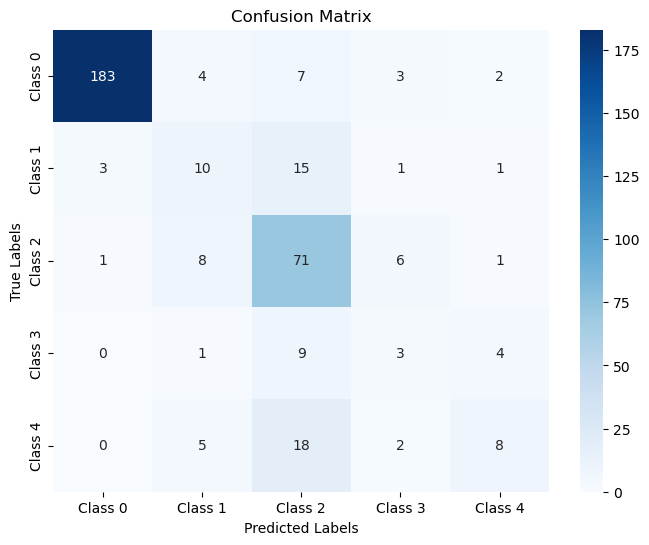

In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model

# Step 1: Load TFRecord Dataset

def parse_tfrecord(tfrecord_file, batch_size=32, img_size=(224, 224)):
    # Define the feature structure of the TFRecord (image, label)
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }

    def _parse_function(proto):
        
    # Define TFRecord schema

    # Parse example
        parsed = tf.io.parse_single_example(proto, feature_description)
    # Decode and preprocess image
        image = tf.io.decode_jpeg(parsed['image'], channels=3)
        image = tf.image.resize(image, TARGET_SIZE) / 255.0  # Normalize
    
        label = tf.one_hot(parsed['label'], depth=NUM_CLASSES)
        return image, label
    
    # Create a dataset from the TFRecord file
    dataset = tf.data.TFRecordDataset(tfrecord_file)
    dataset = dataset.map(_parse_function)  # Apply parsing function to each record
    dataset = dataset.batch(batch_size)  # Batch the dataset
    
    return dataset

# Step 3: Load the Test Dataset from TFRecord
tfrecord_file = '/media/mydisk/ICDCIT/TFRecords_preprocessed_APTOS/test.tfrecord'  # Replace with your TFRecord file path
test_dataset = parse_tfrecord(tfrecord_file)

# Step 4: Make Predictions and Calculate Confusion Matrix
y_true = []
y_pred = []

# Iterate through the dataset and make predictions
for images, labels in test_dataset:
    y_true.append(labels.numpy())  # True labels (one-hot encoded)
    preds = model.predict(images)  # Model predictions (probabilities)
    y_pred.append(np.argmax(preds, axis=1))  # Get class with the highest probability

# Convert lists to numpy arrays
y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

# Step 5: Compute Confusion Matrix
cm = confusion_matrix(np.argmax(y_true, axis=1), y_pred)

# Step 6: Plot Confusion Matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


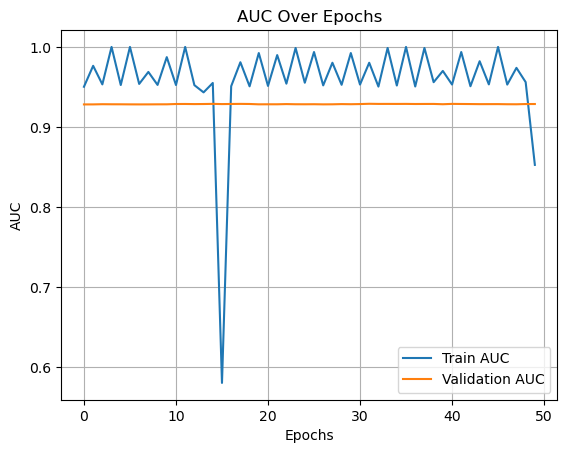

In [21]:
import matplotlib.pyplot as plt

# Assuming `history` is the result of `model.fit`
def plot_auc(history):
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('AUC Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_auc(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


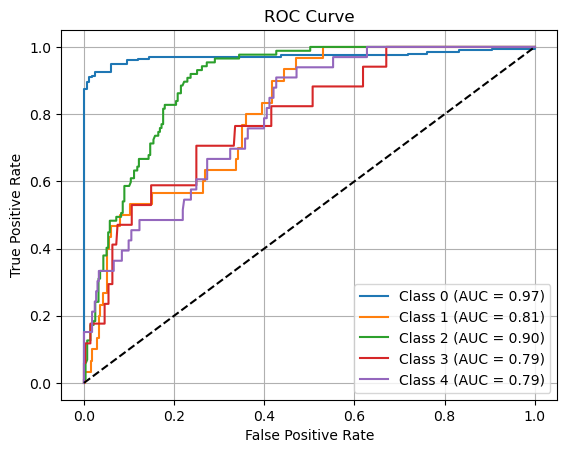

In [22]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Assuming val_dataset contains batched data
y_true = []
y_pred_prob = []

# Extract true labels and predicted probabilities
for images, labels in test_dataset:
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # True labels as integers
    y_pred_prob.extend(model.predict(images))  # Predicted probabilities

y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)

# Compute ROC curve and AUC for each class
n_classes = y_pred_prob.shape[1]  # Number of classes
for i in range(n_classes):
    fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8931 - auc: 0.9812 - loss: 1.3469 - precision_3: 0.9063 - recall_3: 0.8833
Metrics Names: ['loss', 'compile_metrics']
loss: 1.3356841802597046
compile_metrics: 0.9125000238418579
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


2024-12-06 17:29:05.402060: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


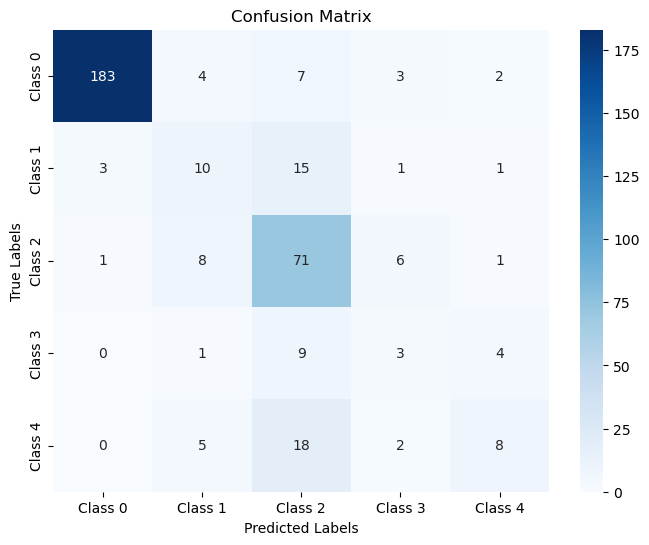

Accuracy: 0.7513661202185792


In [23]:
# Evaluate the model
results = model.evaluate(test_dataset, steps=test_samples // BATCH_SIZE)

# If you want more detailed information about the evaluation:
# Print the metric names
print("Metrics Names:", model.metrics_names)

# Print the evaluation results for each metric
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value}")

# To get more information such as confusion matrix, accuracy, and loss:
y_true = []
y_pred = []

for images, labels in test_dataset:
    y_true.append(labels.numpy())
    preds = model.predict(images)
    y_pred.append(np.argmax(preds, axis=1))

# Convert lists to numpy arrays
y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_true, axis=1), y_pred)

# Plot confusion matrix (optional)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Optionally, calculate accuracy separately
accuracy = np.mean(np.argmax(y_true, axis=1) == y_pred)
print(f"Accuracy: {accuracy}")
